Preamble

In [6]:
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 6, \
                            'figure.facecolor': (1, 1, 1, 0),'font.sans-serif':'Latin Modern Math'}
%matplotlib inline

# Calculating the G, the normalized correlation function

In [7]:
def Calculate_G(image_names, start, time, lags):
    "this function takes image names, a sequence of time and a desired amount of lags"
    "and calculates G, mean quantities, maps"

    def calculate_G(metapixels_a, metapixels_b):
        "this function calculates the value of the normalized correlation"
        "function between metapixels"
        a = np.nanmean((metapixels_a * metapixels_b), axis=(2, 3))
        b = np.nanmean(metapixels_a, axis=(2, 3))
        c = np.nanmean(metapixels_b, axis=(2, 3))
        d = np.nanstd(metapixels_a, axis=(2, 3))
        e = np.nanstd(metapixels_b, axis=(2, 3))

        G = (a - (b * c)) / (d * e)
        return G

    def wholefield_stats(spatial_map, mask):
        map_mean = []
        map_var = []
        for i in range(len(spatial_map)):
            masked_map = ma.masked_array(spatial_map[i], mask=mask)
            map_mean.append(np.nanmean(masked_map))
            map_var.append(np.nanvar(masked_map))
        map_mean = np.asarray(map_mean)
        map_var = np.asarray(map_var)
        return map_mean  #, map_var
##################################################################################################################

#this variable is a list which contains each timestep

    G_time_lags = [[] for _ in range(len(time))]
    sandpile_mean = [[] for _ in range(len(time))]
    sandpile_var = [[] for _ in range(len(time))]

    i = 0

    # this is the size of the metapixels, defined outside of the loop
    size = 10

    for t in time:
        #this is just to make t an interger rather than a float so that t can be used as a list index
        t = int(t)

        #the index of each image (i.e. the frame number) is the iterator t plus 11, the time where grains first
        #enter the frame
        speckle_a = Image.open(image_names[t + start])
        speckle_a = np.asarray(speckle_a)[y_min:y_max, x_min:x_max]

        lenr, lenc = int(speckle_a.shape[0] / size), int(speckle_a.shape[1] /
                                                         size)
        metapixels_a = speckle_a.reshape(lenr, size, lenc,
                                         size).transpose(0, 2, 1, 3)

        mp_a_mean = np.nanmean(metapixels_a, axis=(2, 3))
        metapixels_a = np.subtract(metapixels_a,
                                   mp_a_mean[..., np.newaxis, np.newaxis])

##################################################################################################################
        l = 0
        G_lags = [[] for _ in range(lags)]

        # this loop is for each lag
        for lag in range(lags):

            # choosing two speckle images
            speckle_b = Image.open(image_names[lag + t + start])
            speckle_b = np.asarray(speckle_b)[y_min:y_max, x_min:x_max]

            metapixels_b = speckle_b.reshape(lenr, size, lenc,
                                             size).transpose(0, 2, 1, 3)
            mp_b_mean = np.nanmean(metapixels_b, axis=(2, 3))
            metapixels_b = np.subtract(metapixels_b,
                                       mp_b_mean[..., np.newaxis, np.newaxis])

            G_lags[l] = (calculate_G(metapixels_a, metapixels_b))
            
            l += 1
        #this is a new piece to ensure that any correlation values < 0 are set to 0. 
        #(negative correlations are unphysical)
#         G_lags[G_lags <= 0] = 0
##################################################################################################################
        G_time_lags[i] = G_lags
        sandpile_mean[i] = wholefield_stats(G_time_lags[i], mask=~binary)

        i += 1
        print(t+start)

    return G_time_lags, sandpile_mean

# Materials

## Sand

### Loading images

In [10]:
import glob
import natsort

image_names = []

for name in glob.glob('/media/ndeshpande/My Passport/data/Hillslope_DWS/2019_experiments/materials/100um_sand/A/img_*.jpg'):
    image_names.append(name)

image_names = natsort.natsorted(image_names,reverse=False)
timestep = len(image_names)

### Creating masks

In [11]:
#specify the bounds of the image - should be evenly divisible by the metapixel size
x_min = 0
x_max = 1800
y_min = 0
y_max = 1400

# choosing two speckle images
speckle_a = Image.open(image_names[50])
speckle_a = np.asarray(speckle_a)[y_min:y_max,x_min:x_max]

speckle_b = Image.open(image_names[60])
speckle_b = np.asarray(speckle_b)[y_min:y_max,x_min:x_max]
    
# partitioning images into metpixels
size = 10
a = speckle_a
lenr, lenc = int(a.shape[0]/size), int(a.shape[1]/size)
## 'flattening' the metapixel array along a single axis
metapixels_a = speckle_a.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)

b = speckle_b
lenr, lenc = int(b.shape[0]/size), int(b.shape[1]/size)
metapixels_b = speckle_b.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)
    
metapixel_grid_rows = metapixels_a.shape[0]
metapixel_grid_columns = metapixels_a.shape[1]
metapixel_grid_area = metapixel_grid_rows*metapixel_grid_columns

In [12]:
mp_a_mean = np.mean(metapixels_a,axis = (2,3))
mp_b_mean = np.mean(metapixels_b,axis = (2,3))

## Adding [...,np.newaxis,np.newaxis] allows the array of means to be subtracted
## from the array containing metapixels. otherwise, their shapes are not the same
metapixels_a = np.subtract(metapixels_a,mp_a_mean[..., np.newaxis,np.newaxis])
metapixels_b = np.subtract(metapixels_b,mp_b_mean[..., np.newaxis,np.newaxis])

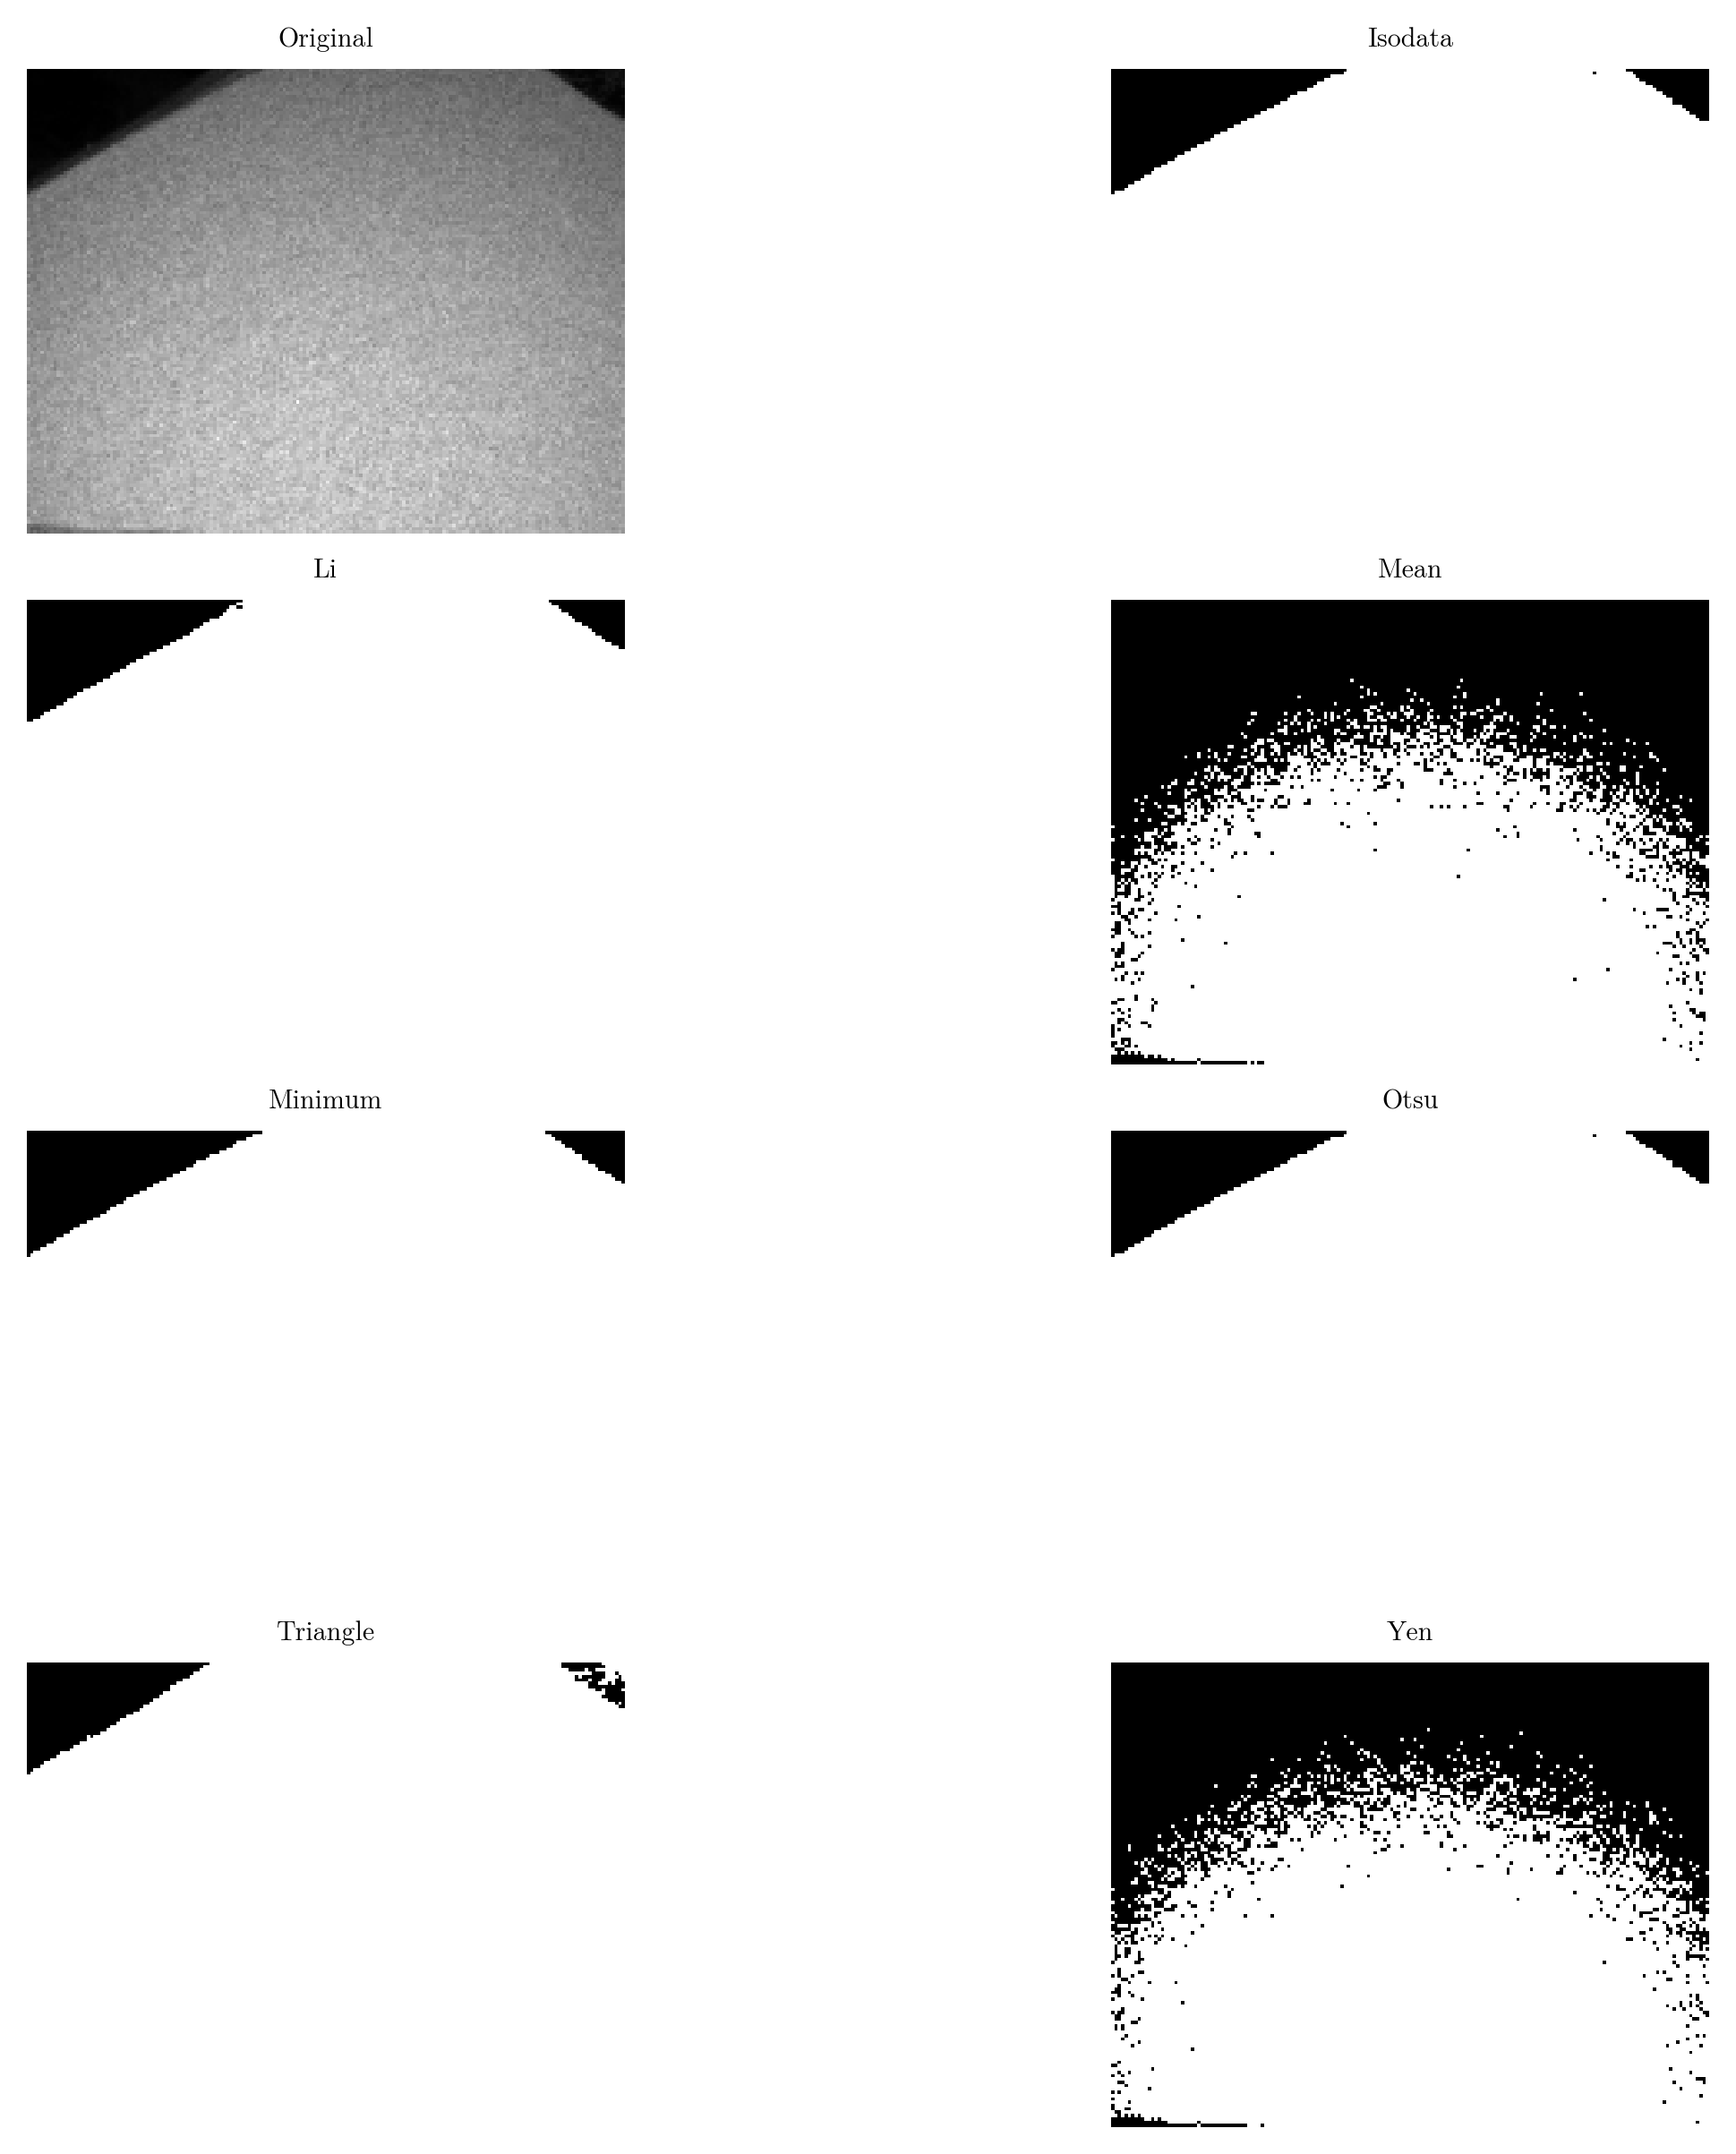

In [13]:
from skimage.filters import try_all_threshold

img = mp_a_mean

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

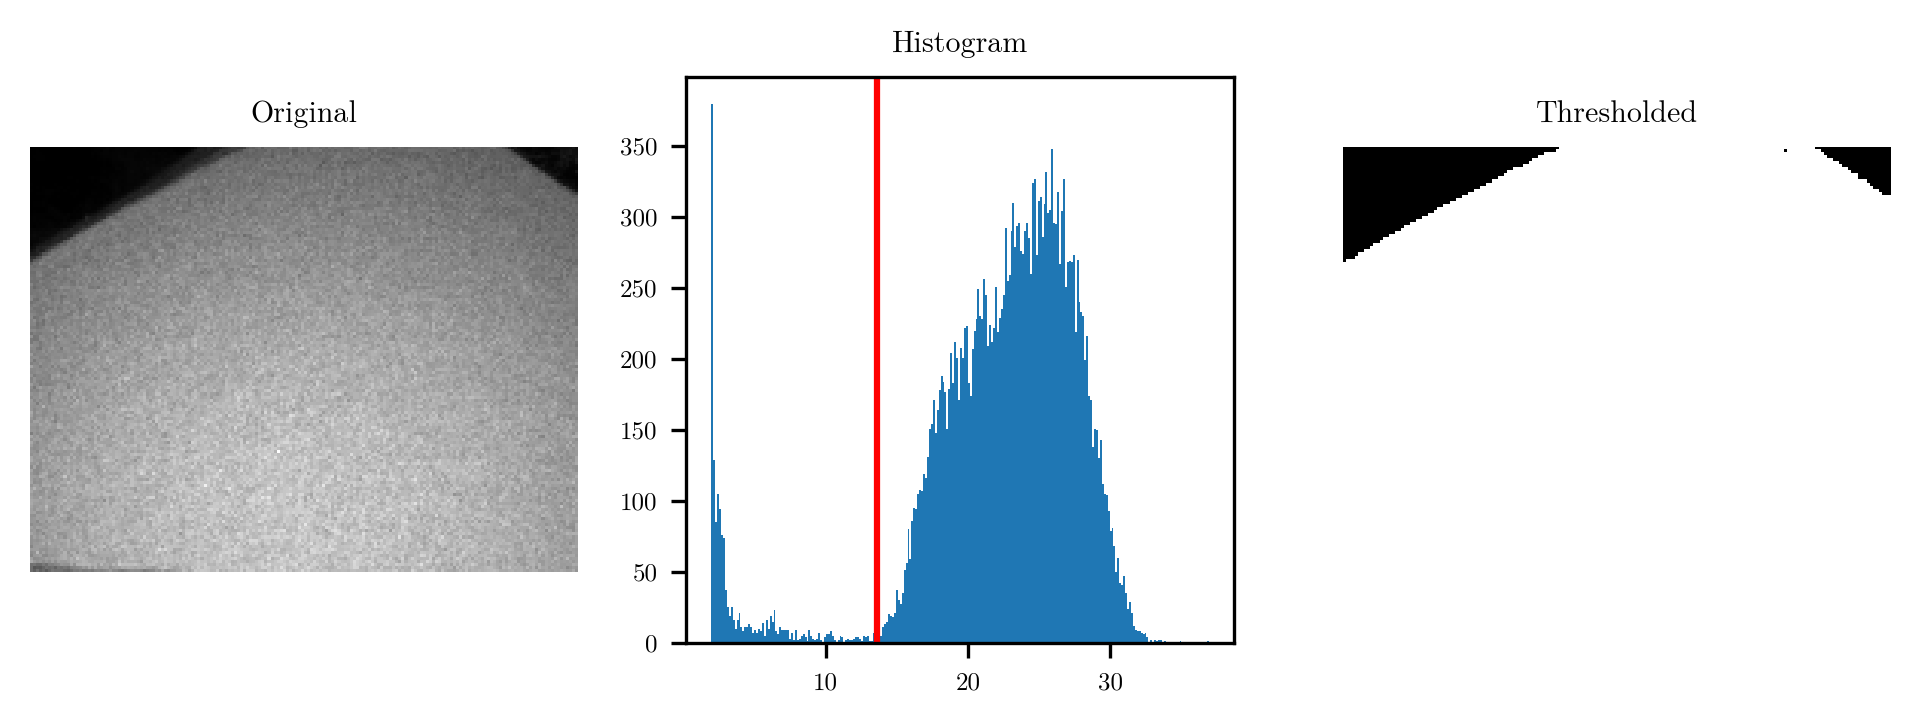

In [14]:
from skimage.filters import threshold_otsu
image = mp_a_mean
thresh = threshold_otsu(image)
binary = image > thresh
mask_sand = ~binary

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

### Calculating G

In [8]:
time = np.logspace(1, 13, num=13, base=2)
# time = (0,10,25,50,100,250,500)
# time = np.arange (0,161,1)

correlation_sand, means_sand = Calculate_G(image_names,16,time,1000)

/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


18
20
24
32
48
80
144
272
528
1040
2064
4112
8208


In [11]:
np.savez('sand_means',data1 = correlation_sand, data2 = means_sand)

In [16]:
sand = np.load('/home/ndeshpande/Documents/Python Scripts/DWS_Speckle_Analysis/outputs/2019/sand_means.npz')
correlation_sand = sand['data1']
means_sand = sand['data2']

### 2d maps

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 1, 1)
# ax2 = plt.subplot(1, 2, 2)

a = correlation_sand[9][1]
a[a <= 0] = 0

masked_map = ma.masked_array(a, mask=~binary)

im1 = ax1.imshow(masked_map,vmin = .9,vmax = 1,cmap = 'gray')

cmap = plt.cm.gray_r
cmap.set_bad('white',1.)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
# cax.tick_params(labelsize=15) 
cax.set_title('G')#,fontsize = 15)

# ax1.set_title('t = 16 s, τ = 1')#,fontsize = 20);
# ax1.set_xlim([30,175]);
ax1.set_xticks([]);
ax1.set_yticks([]);

### Relaxation curves

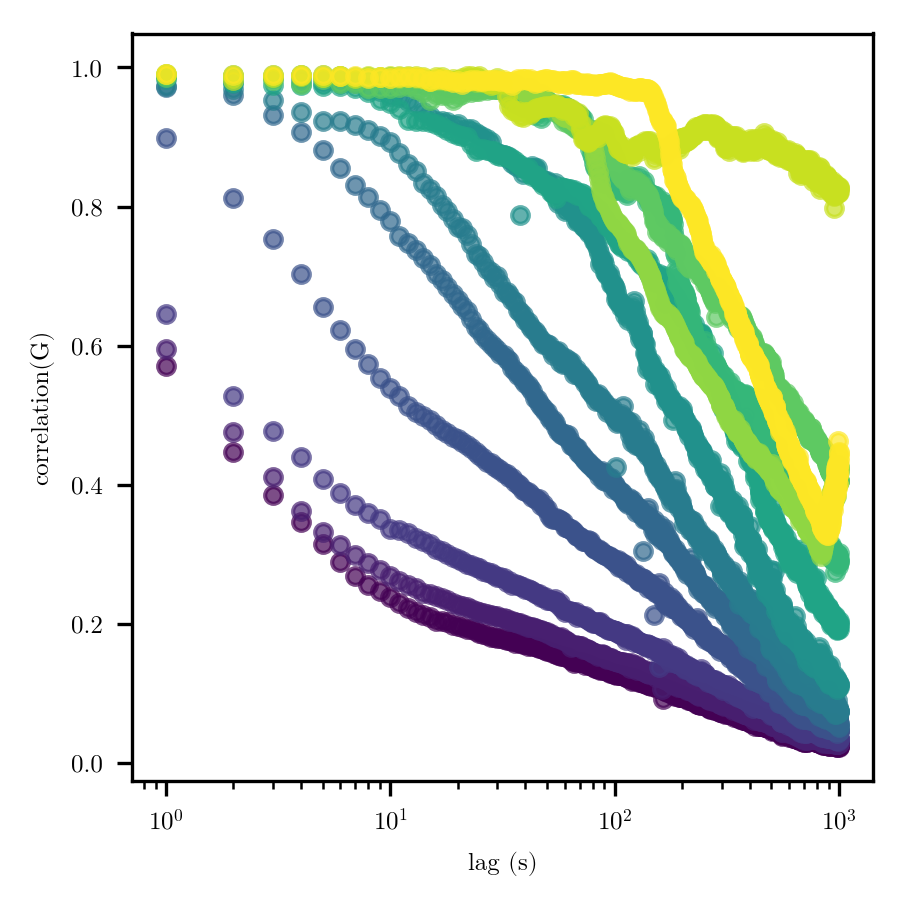

In [4]:
from matplotlib.pyplot import cm

# labels = list(time)
# labels = list(np.logspace(1, 13, num=13, base=2))

# t = np.arange(0,10,.1)

color=iter(cm.viridis(np.linspace(0,1,13)))

fig = plt.figure(figsize=(3, 3))
ax1 = plt.subplot(111)

for t in range(13):
    c=next(color)
    ax1.plot(means_sand[t],'o',color = c,markersize = 4,alpha = 0.7)#,label = int(labels[t]))

ax1.set_xscale('log')
ax1.set_xlabel('lag (s)')
ax1.set_ylabel('correlation(G)')

# box = ax1.get_position()
# lgd = ax1.legend()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(title = 'start time',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# plt.savefig('heat.png')

In [6]:
t_efold = []
test = []

for i in range(len(means_sand)):
    x = means_sand[i]
    y = np.where(x < 1/np.exp(1))[0]
    t_efold.append(y[0])

IndexError: index 0 is out of bounds for axis 0 with size 0

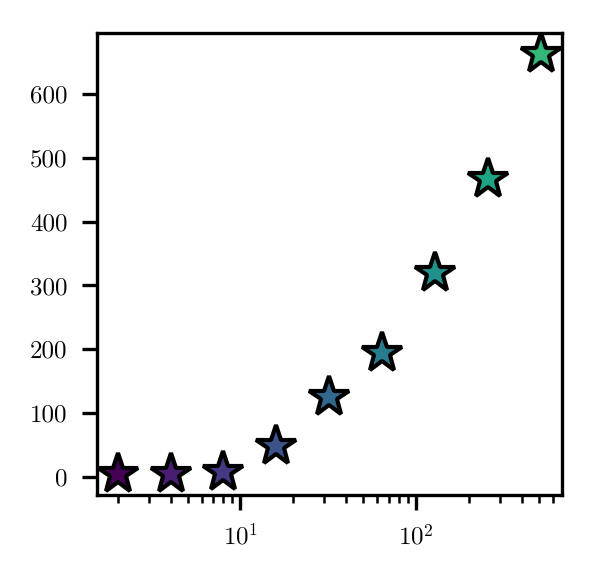

In [16]:
fig = plt.figure(figsize=(2, 2))
labels = (list(np.logspace(1, 13, num=13, base=2)))

t = (np.logspace(1, 13, num=13, base=2))
color=iter(cm.viridis(np.linspace(0,1,13)))

for i in range(len(t_efold)):
    c=next(color)
    plt.plot(t[i],t_efold[i],'*',label = labels[i],markeredgecolor = 'k',color = c,markersize = 10)
plt.xscale('log')
# plt.yscale('log')

# x = np.arange(1,500,1)
# y = np.log(x)
# plt.plot(x,y)

### Time-Series

In [ ]:
from matplotlib.pyplot import cm

# labels = list(time)
# labels = list(np.logspace(1, 13, num=13, base=2))

# t = np.arange(0,10,.1)

color=iter(cm.viridis(np.linspace(0,1,100)))

fig = plt.figure(figsize=(3, 3))
ax1 = plt.subplot(111)

for t in range(100):
    c=next(color)
    ax1.plot(t,sandpile_means[t][1],'o',color = c,markersize = 4,alpha = 0.7)#,label = int(labels[t]))

# ax1.set_xscale('log')
ax1.set_xlabel('lag (s)')
ax1.set_ylabel('correlation(G)')

# box = ax1.get_position()
# lgd = ax1.legend()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(title = 'start time',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# plt.savefig('heat.png')

## 50% mix

### Loading images

### Creating masks

In [12]:
import glob
import natsort

image_names = []

for name in glob.glob('/media/ndeshpande/My Passport/data/Hillslope_DWS/materials/50%_mixture/A/img_*.jpg'):
    image_names.append(name)

image_names = natsort.natsorted(image_names,reverse=False)
timestep = len(image_names)

In [13]:
#specify the bounds of the image - should be evenly divisible by the metapixel size
x_min = 0
x_max = 1800
y_min = 0
y_max = 1400

# choosing two speckle images
speckle_a = Image.open(image_names[50])
speckle_a = np.asarray(speckle_a)[y_min:y_max,x_min:x_max]

speckle_b = Image.open(image_names[60])
speckle_b = np.asarray(speckle_b)[y_min:y_max,x_min:x_max]
    
# partitioning images into metpixels
size = 10
a = speckle_a
lenr, lenc = int(a.shape[0]/size), int(a.shape[1]/size)
## 'flattening' the metapixel array along a single axis
metapixels_a = speckle_a.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)

b = speckle_b
lenr, lenc = int(b.shape[0]/size), int(b.shape[1]/size)
metapixels_b = speckle_b.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)
    
metapixel_grid_rows = metapixels_a.shape[0]
metapixel_grid_columns = metapixels_a.shape[1]
metapixel_grid_area = metapixel_grid_rows*metapixel_grid_columns

In [14]:
mp_a_mean = np.mean(metapixels_a,axis = (2,3))
mp_b_mean = np.mean(metapixels_b,axis = (2,3))

## Adding [...,np.newaxis,np.newaxis] allows the array of means to be subtracted
## from the array containing metapixels. otherwise, their shapes are not the same
metapixels_a = np.subtract(metapixels_a,mp_a_mean[..., np.newaxis,np.newaxis])
metapixels_b = np.subtract(metapixels_b,mp_b_mean[..., np.newaxis,np.newaxis])

/home/ndeshpande/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


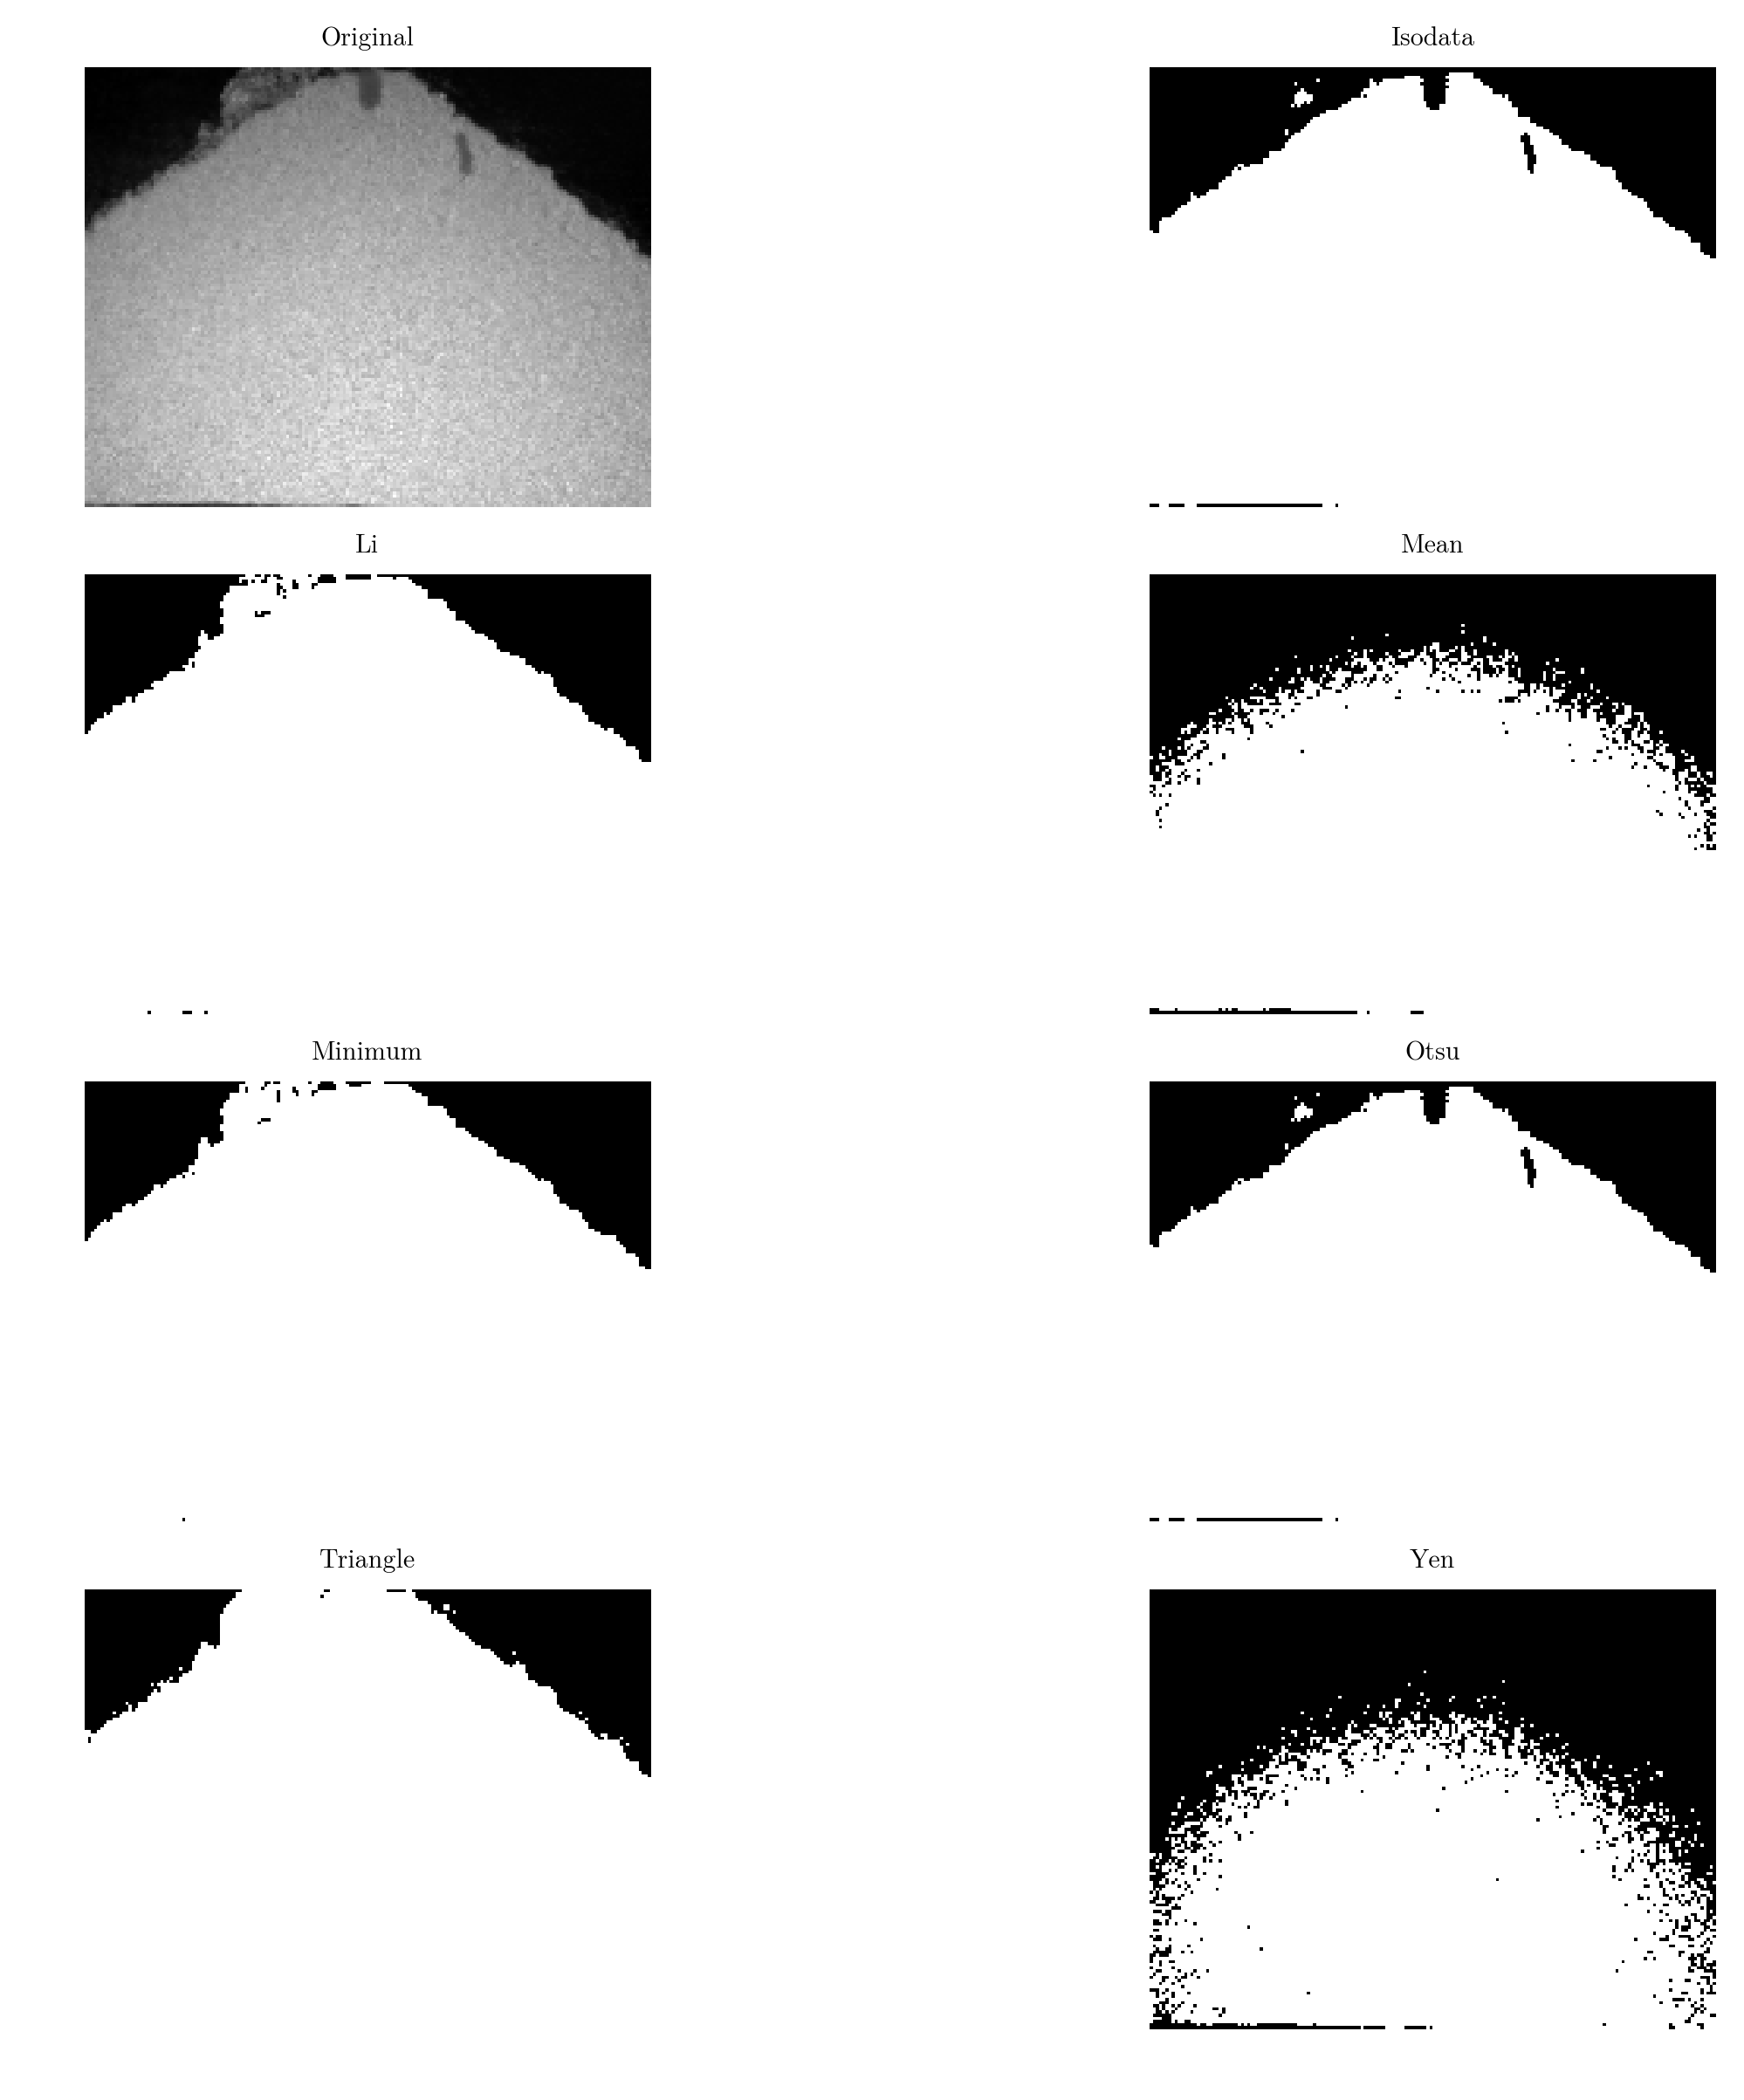

In [15]:
from skimage.filters import try_all_threshold

img = mp_a_mean

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

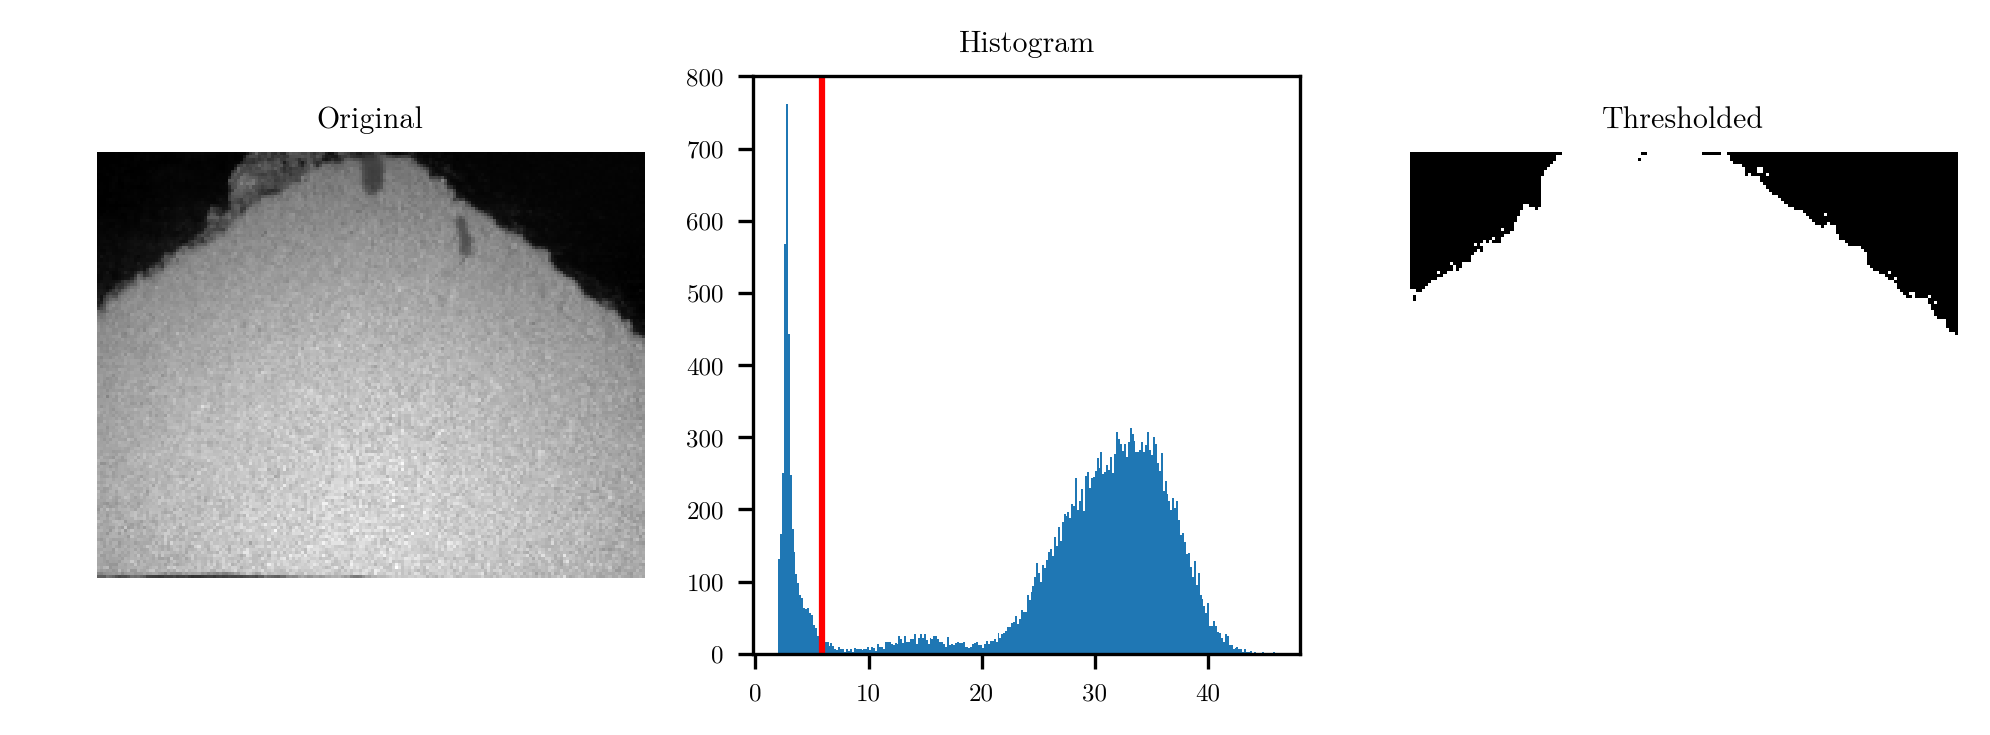

In [16]:
from skimage.filters import threshold_triangle
image = mp_a_mean
thresh = threshold_triangle(image)
binary = image > thresh
mask_mix = ~binary

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

In [95]:
### if you need to fill in holes in the thresholded image:

In [ ]:
import scipy.ndimage.morphology 
# scipy.ndimage.morphology.binary_fill_holes¶
# segmentation = ndimage.binary_fill_holes(segmentation - 1)

# mask = scipy.ndimage.morphology.binary_fill_holes(binary)
# plt.imshow(mask)

### Calculating G

In [17]:
time = np.logspace(1, 13, num=13, base=2)
# time = (0,10,25,50,100,250,500)
# time = np.arange (0,161,1)

correlation_mix, means_mix = Calculate_G(image_names,53,time,1000)

/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


55
57
61
69
85
117
181
309
565
1077
2101
4149
8245


In [20]:
np.savez('mix_means',data1 = correlation_mix, data2 = means_mix)

### 2d maps

/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


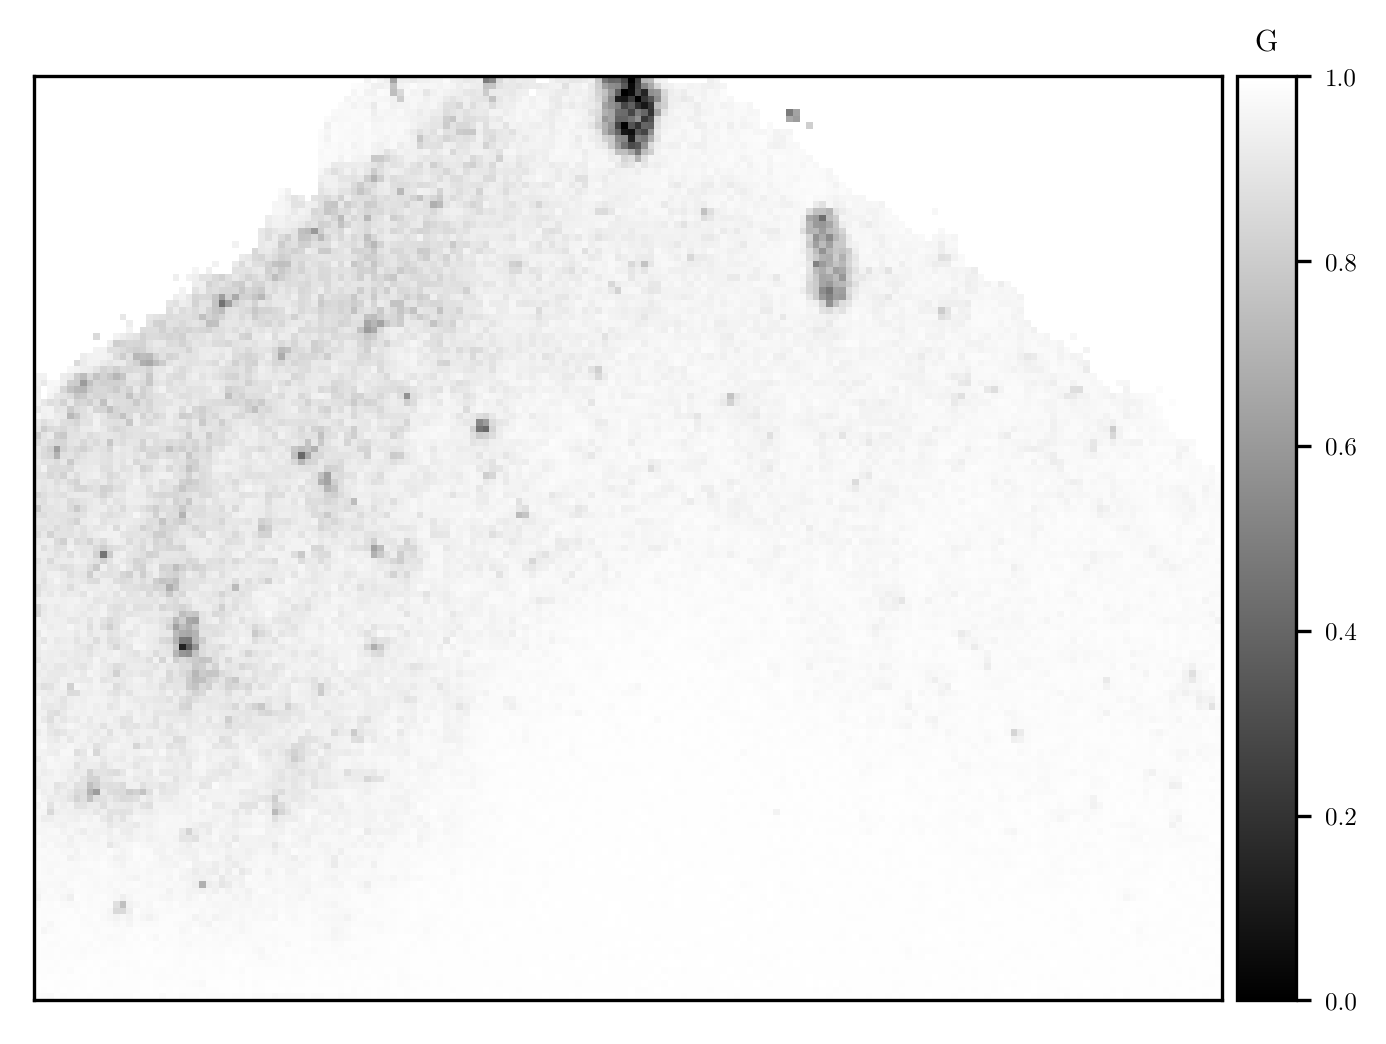

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 1, 1)
# ax2 = plt.subplot(1, 2, 2)

a = correlation_mix[7][1]
a[a <= 0] = 0

masked_map = ma.masked_array(a, mask=~binary)

im1 = ax1.imshow(masked_map,vmin = 0,vmax = 1,cmap = 'gray')

cmap = plt.cm.gray_r
cmap.set_bad('white',1.)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
# cax.tick_params(labelsize=15) 
cax.set_title('G')#,fontsize = 15)

# ax1.set_title('t = 16 s, τ = 1')#,fontsize = 20);
# ax1.set_xlim([30,175]);
ax1.set_xticks([]);
ax1.set_yticks([]);

### Relaxation curves

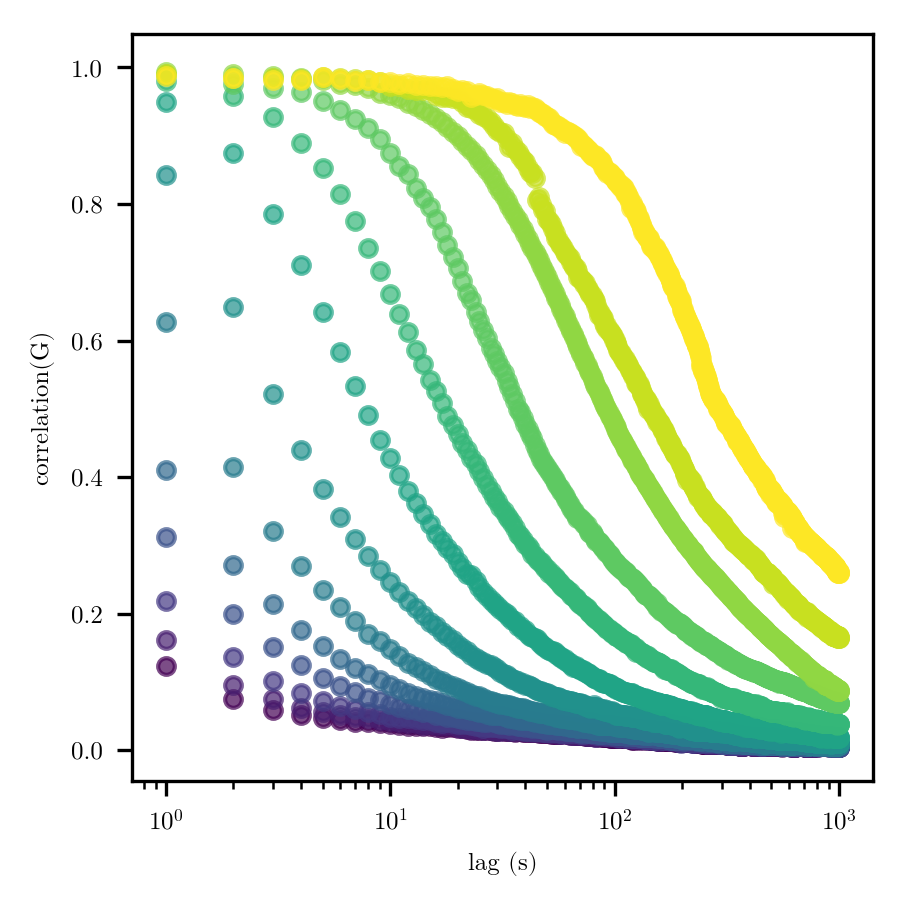

In [19]:
from matplotlib.pyplot import cm

# labels = list(time)
# labels = list(np.logspace(1, 13, num=13, base=2))

# t = np.arange(0,10,.1)

color=iter(cm.viridis(np.linspace(0,1,13)))

fig = plt.figure(figsize=(3, 3))
ax1 = plt.subplot(111)

for t in range(13):
    c=next(color)
    ax1.plot(means_mix[t],'o',color = c,markersize = 4,alpha = 0.7)#,label = int(labels[t]))

ax1.set_xscale('log')
ax1.set_xlabel('lag (s)')
ax1.set_ylabel('correlation(G)')

# box = ax1.get_position()
# lgd = ax1.legend()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(title = 'start time',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# plt.savefig('heat.png')

## Kaolinite

### Loading images

In [31]:
import glob
import natsort

image_names = []

for name in glob.glob('/media/ndeshpande/My Passport/data/Hillslope_DWS/materials/kaolinite/A/img_*.jpg'):
    image_names.append(name)

image_names = natsort.natsorted(image_names,reverse=False)
timestep = len(image_names)

### Creating masks

In [32]:
#specify the bounds of the image - should be evenly divisible by the metapixel size
x_min = 0
x_max = 1800
y_min = 0
y_max = 1400

# choosing two speckle images
speckle_a = Image.open(image_names[50])
speckle_a = np.asarray(speckle_a)[y_min:y_max,x_min:x_max]

speckle_b = Image.open(image_names[60])
speckle_b = np.asarray(speckle_b)[y_min:y_max,x_min:x_max]
    
# partitioning images into metpixels
size = 10
a = speckle_a
lenr, lenc = int(a.shape[0]/size), int(a.shape[1]/size)
## 'flattening' the metapixel array along a single axis
metapixels_a = speckle_a.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)

b = speckle_b
lenr, lenc = int(b.shape[0]/size), int(b.shape[1]/size)
metapixels_b = speckle_b.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)
    
metapixel_grid_rows = metapixels_a.shape[0]
metapixel_grid_columns = metapixels_a.shape[1]
metapixel_grid_area = metapixel_grid_rows*metapixel_grid_columns

In [33]:
mp_a_mean = np.mean(metapixels_a,axis = (2,3))
mp_b_mean = np.mean(metapixels_b,axis = (2,3))

## Adding [...,np.newaxis,np.newaxis] allows the array of means to be subtracted
## from the array containing metapixels. otherwise, their shapes are not the same
metapixels_a = np.subtract(metapixels_a,mp_a_mean[..., np.newaxis,np.newaxis])
metapixels_b = np.subtract(metapixels_b,mp_b_mean[..., np.newaxis,np.newaxis])

/home/ndeshpande/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


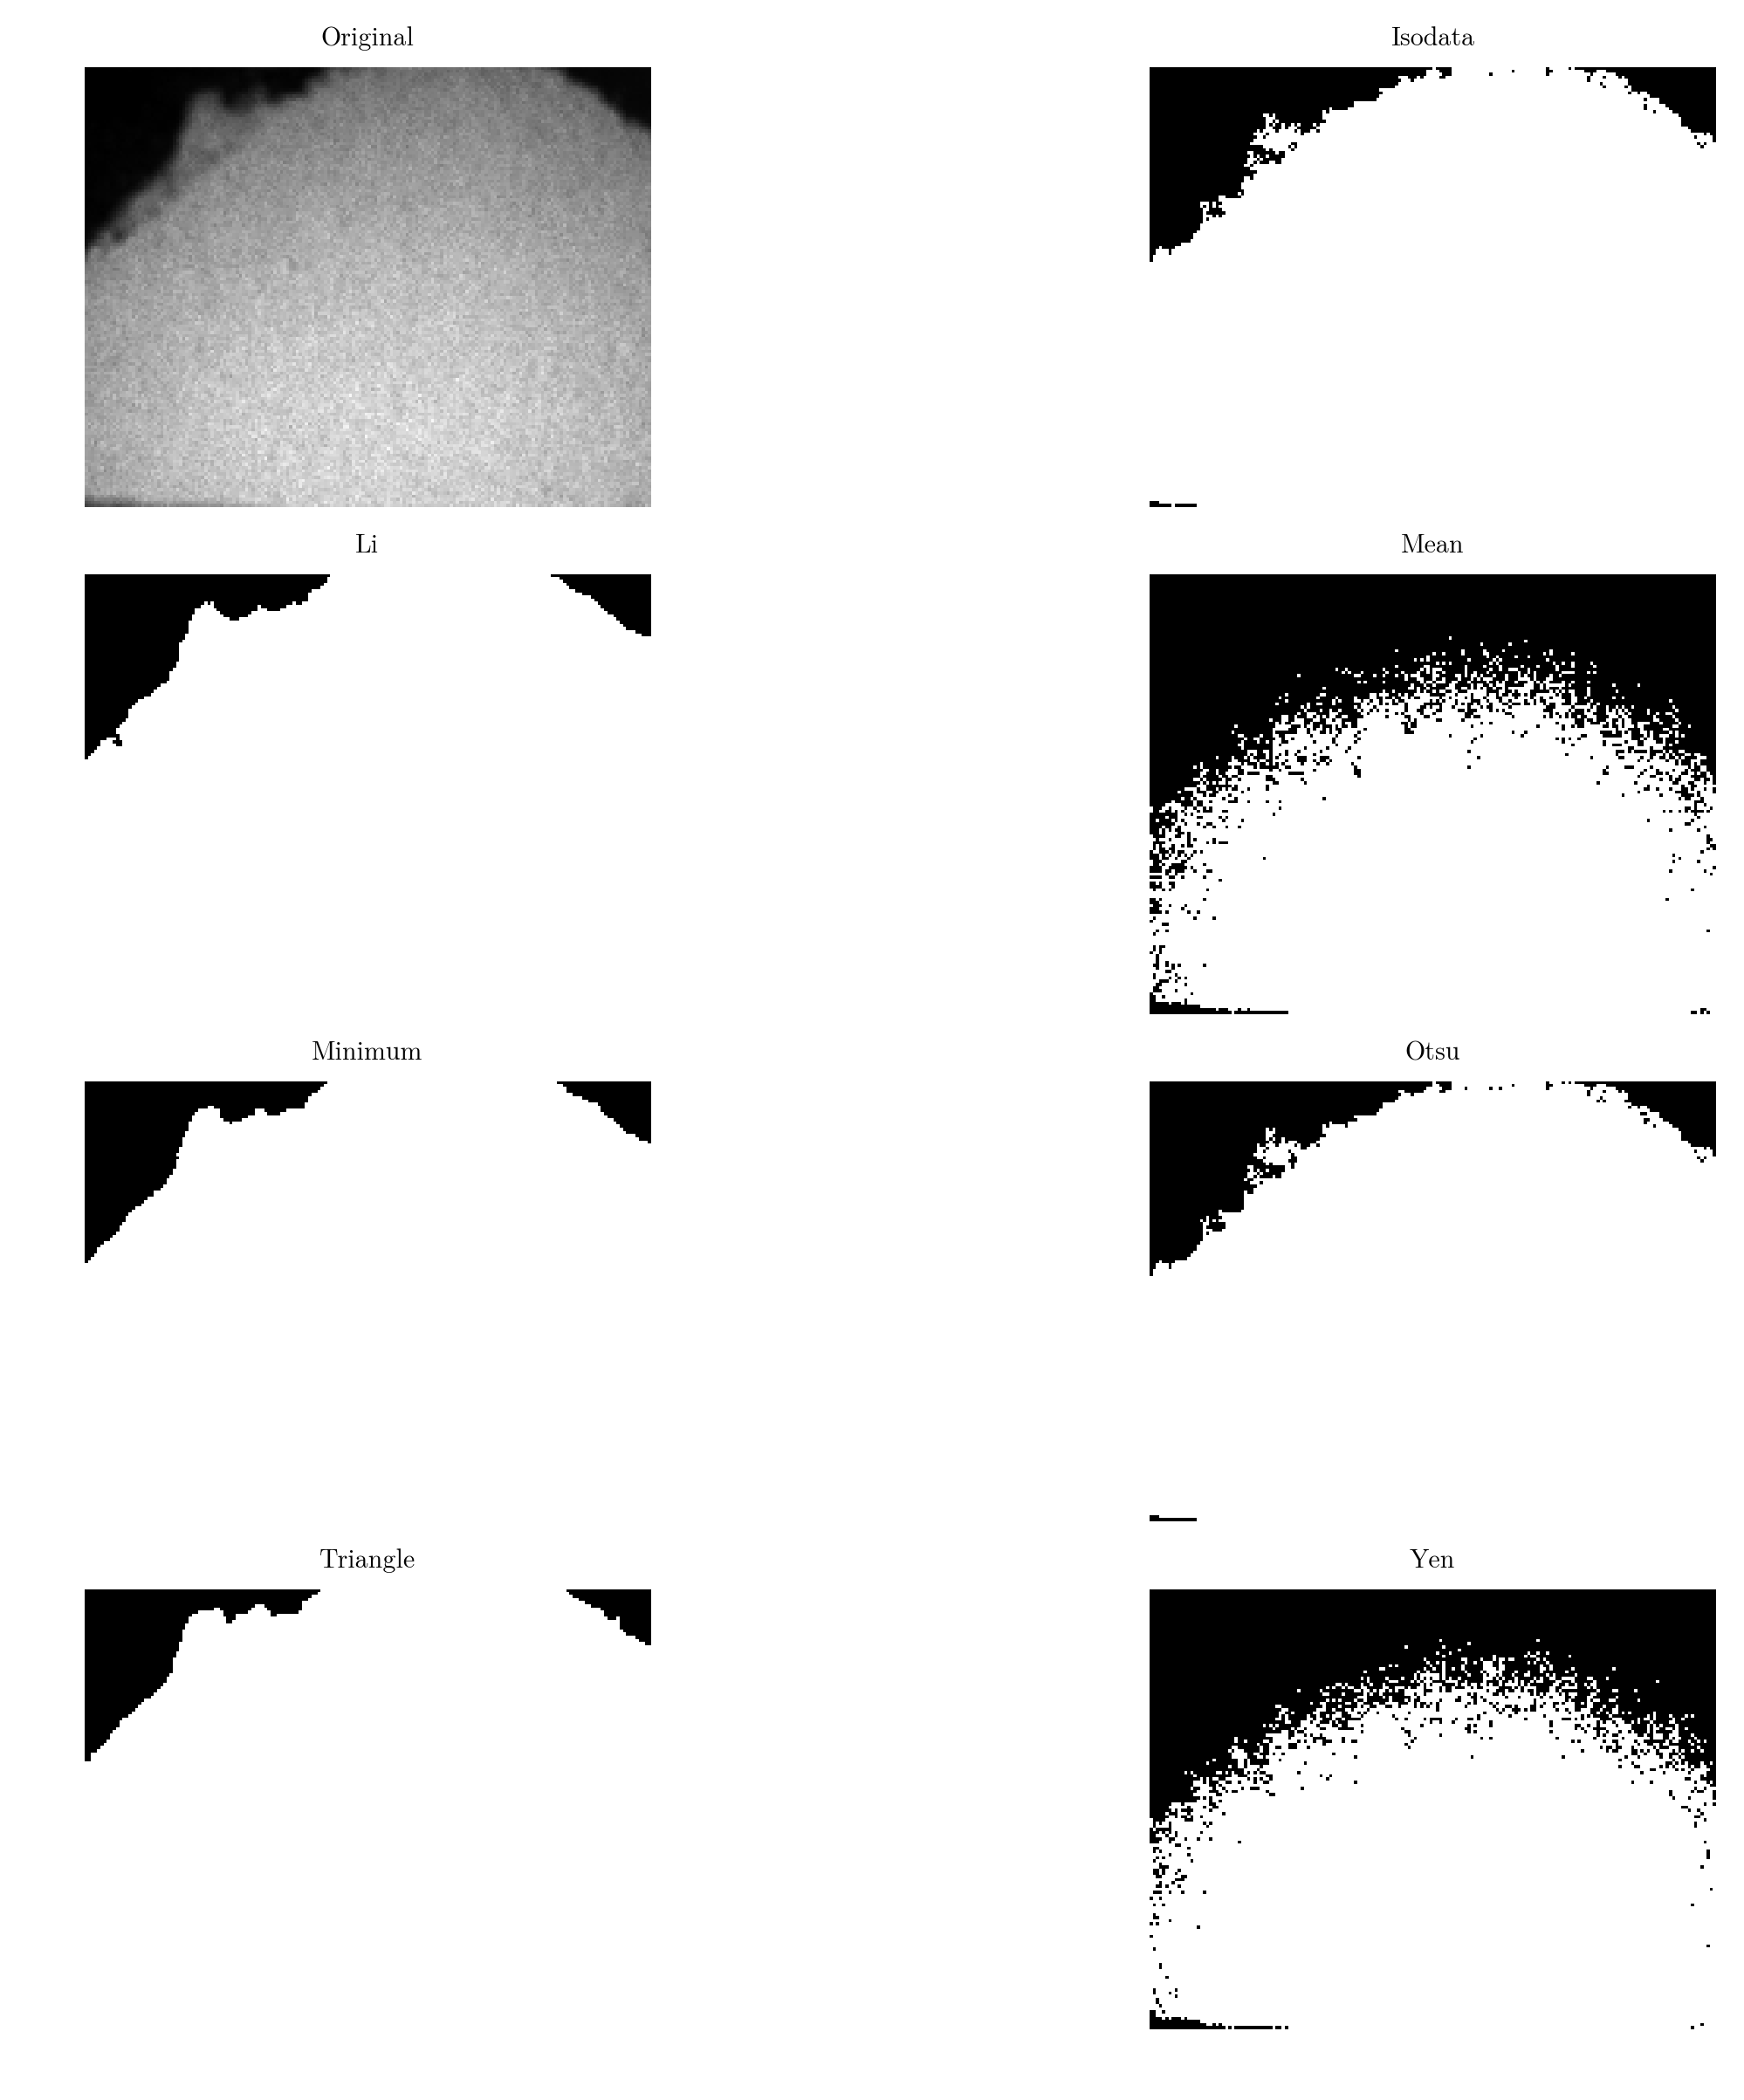

In [34]:
from skimage.filters import try_all_threshold

img = mp_a_mean

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

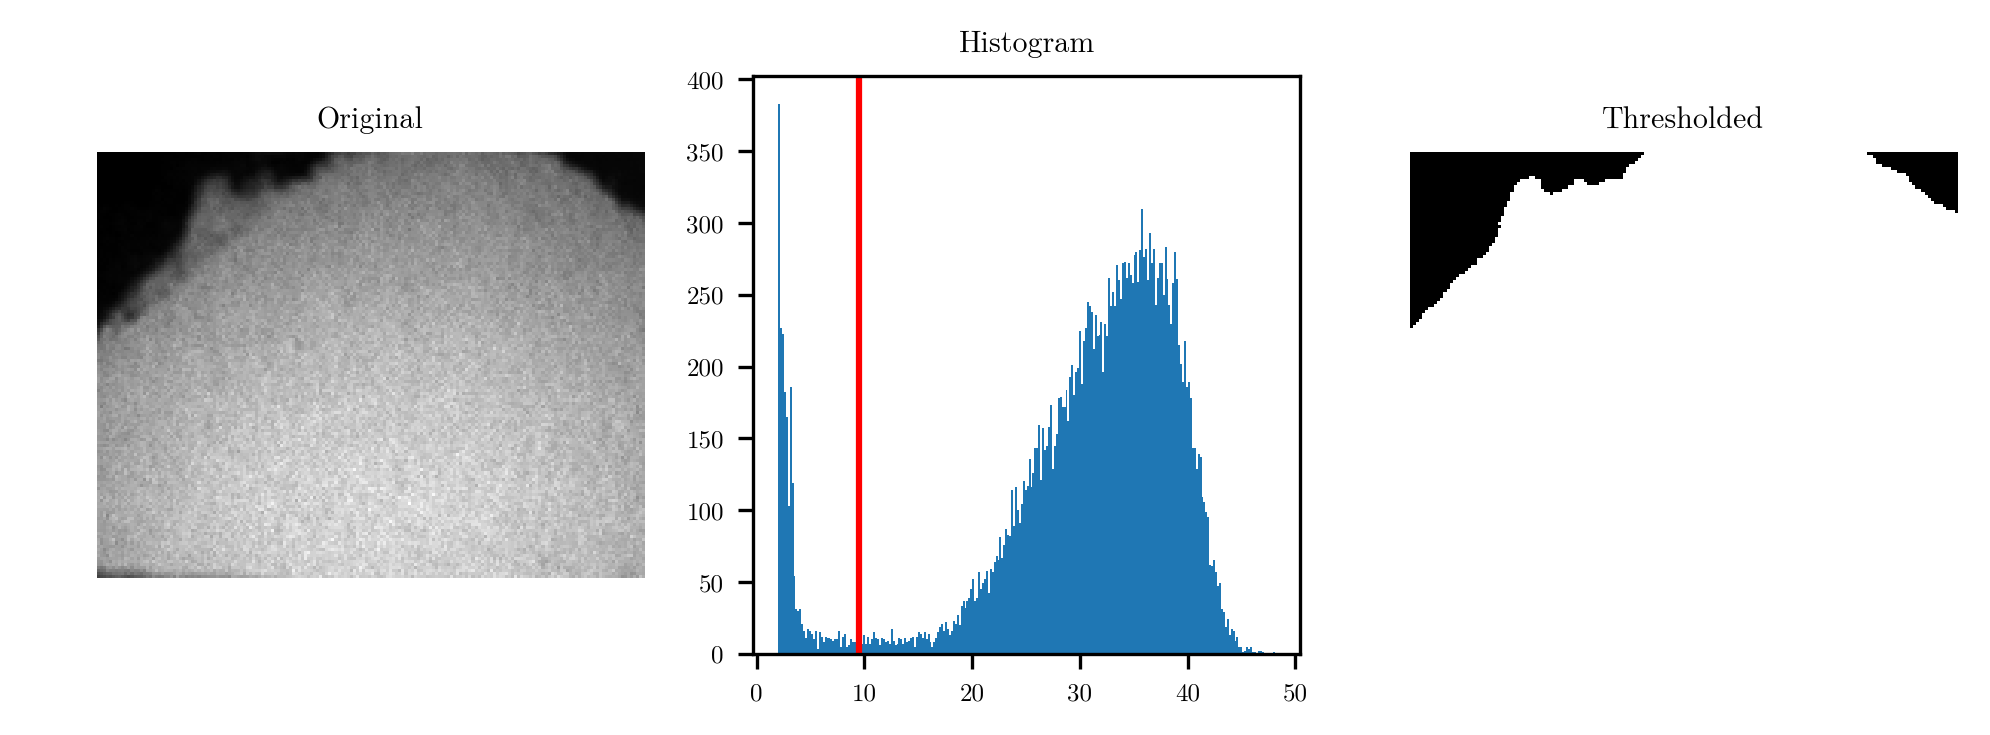

In [35]:
from skimage.filters import threshold_minimum
image = mp_a_mean
thresh = threshold_minimum(image)
binary = image > thresh
mask_kaolinite = ~binary

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

### Calculating G

In [26]:
time = np.logspace(1, 13, num=13, base=2)
# time = (0,10,25,50,100,250,500)
# time = np.arange (0,161,1)

correlation_kaolinite, means_kaolinite = Calculate_G(image_names,53,time,1000)

/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


55
57
61
69
85
117
181
309
565
1077
2101
4149
8245


In [29]:
np.savez('kaolinite_means',data1 = correlation_kaolinite, data2 = means_kaolinite)

### 2d maps

In [38]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
t = 40

/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


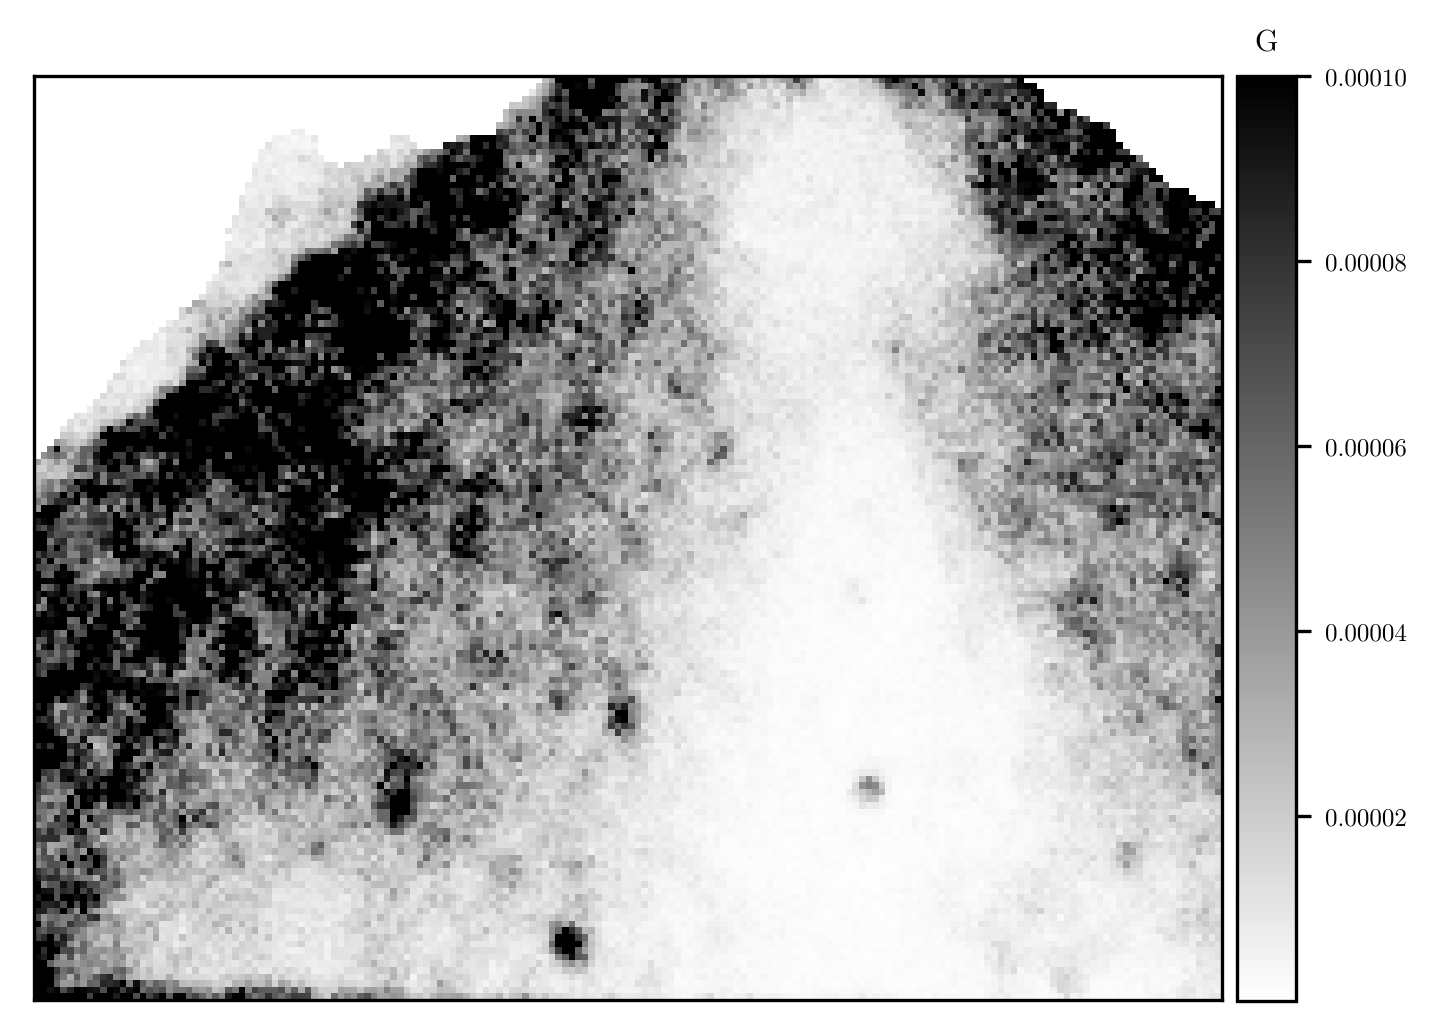

In [39]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 1, 1)
# ax2 = plt.subplot(1, 2, 2)

a = correlation_kaolinite[2][1]
a[a <= 0] = 1e-32

masked_map = ma.masked_array(a, mask=~binary)

masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-4,cmap = 'gray_r')

cmap = plt.cm.gray_r
cmap.set_bad('white',1.)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
# cax.tick_params(labelsize=15) 
cax.set_title('G')#,fontsize = 15)

# ax1.set_title('t = 16 s, τ = 1')#,fontsize = 20);
# ax1.set_xlim([30,175]);
ax1.set_xticks([]);
ax1.set_yticks([]);

### Relaxation curves

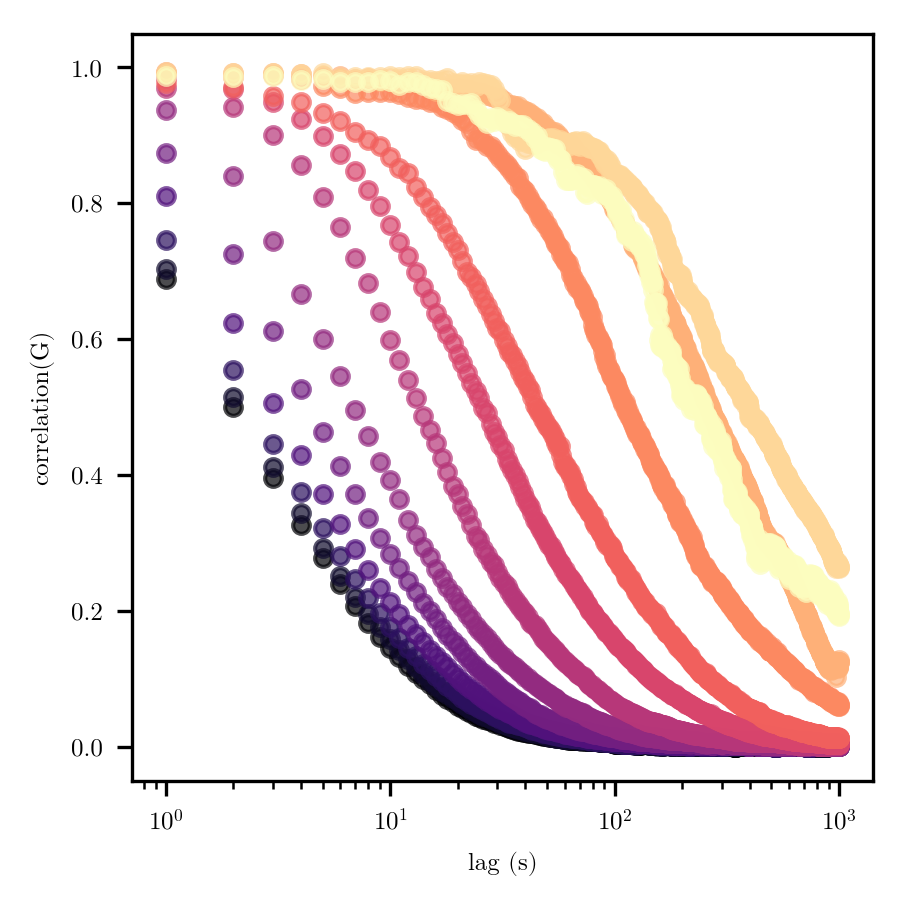

In [44]:
from matplotlib.pyplot import cm

# labels = list(time)
# labels = list(np.logspace(1, 13, num=13, base=2))

# t = np.arange(0,10,.1)

color=iter(cm.magma(np.linspace(0,1,13)))

fig = plt.figure(figsize=(3, 3))
ax1 = plt.subplot(111)

for t in range(13):
    c=next(color)
    ax1.plot(means_kaolinite[t],'o',color = c,markersize = 4,alpha = 0.7)#,label = int(labels[t]))

ax1.set_xscale('log')
ax1.set_xlabel('lag (s)')
ax1.set_ylabel('correlation(G)')

# box = ax1.get_position()
# lgd = ax1.legend()
# ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax1.legend(title = 'start time',loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

plt.tight_layout()

# plt.savefig('heat.png')

## Ensemble material relaxation

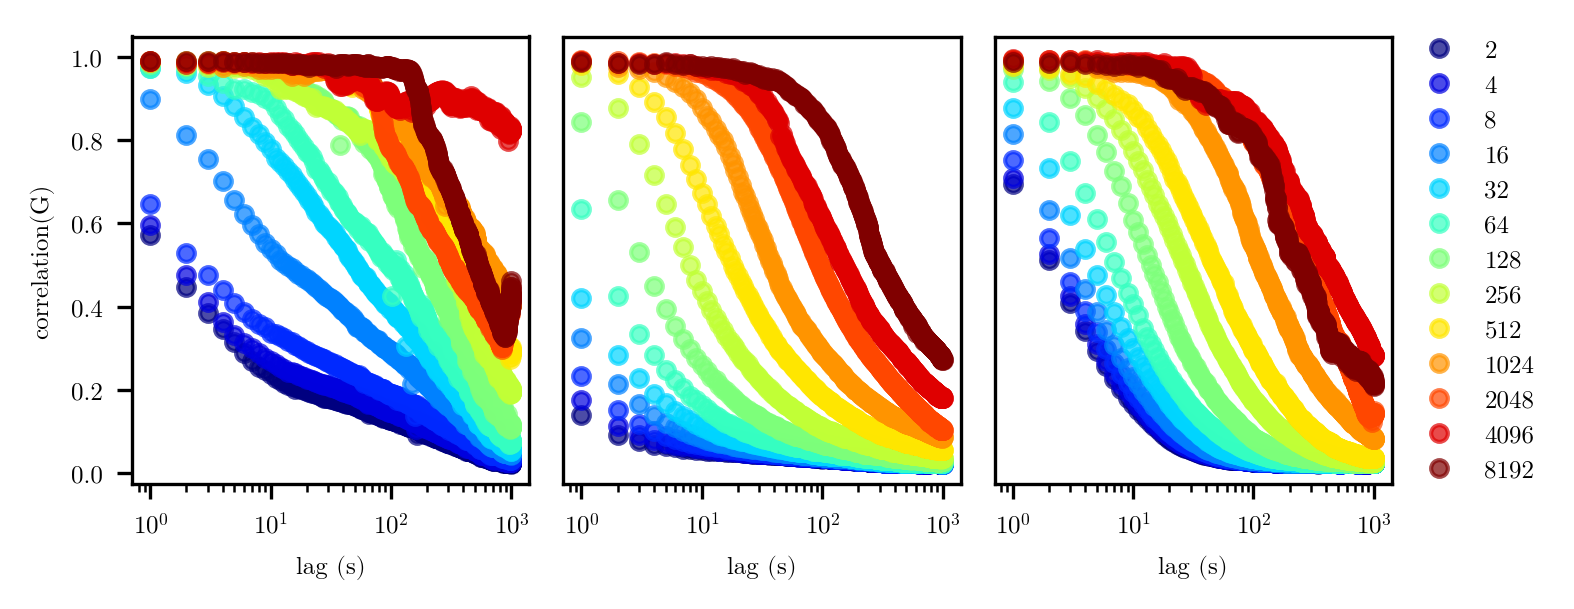

In [83]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
t = 1

fig = plt.figure(figsize=(5, 2))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

# fig.suptitle('heating test - 10 cycles')
#################################################################################################################
color=iter(cm.jet(np.linspace(0,1,13)))

for t in range(13):
    c=next(color)
    ax1.plot(means_sand[t],'o',color = c,markersize = 4,alpha = 0.7,label = int(labels[t]))

ax1.set_xscale('log')
ax1.set_xlabel('lag (s)')
ax1.set_ylabel('correlation(G)')

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
# cax.set_title('$\epsilon$')

#################################################################################################################
color=iter(cm.jet(np.linspace(0,1,13)))

for t in range(13):
    c=next(color)
    ax2.plot(means_mix[t],'o',color = c,markersize = 4,alpha = 0.7)#,label = int(labels[t]))

ax2.set_yticks([])
ax2.set_xscale('log')
ax2.set_xlabel('lag (s)')

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
# cax.set_title('$\epsilon$')
#################################################################################################################
color=iter(cm.jet(np.linspace(0,1,13)))

labels = list(np.logspace(1, 13, num=13, base=2))

for t in range(13):
    c=next(color)
    ax3.plot(means_kaolinite[t],'o',color = c,markersize = 4,alpha = 0.7,label = int(labels[t]))

ax3.legend()
ax3.set_yticks([])
ax3.set_xscale('log')
ax3.set_xlabel('lag (s)')


box = ax3.get_position()
lgd = ax3.legend()
ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax3.legend(loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))


plt.tight_layout()

# plt.savefig('heating_tapping.png')

## Ensemble material maps

In [51]:
t = 500

/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less_equal
/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in less_equal


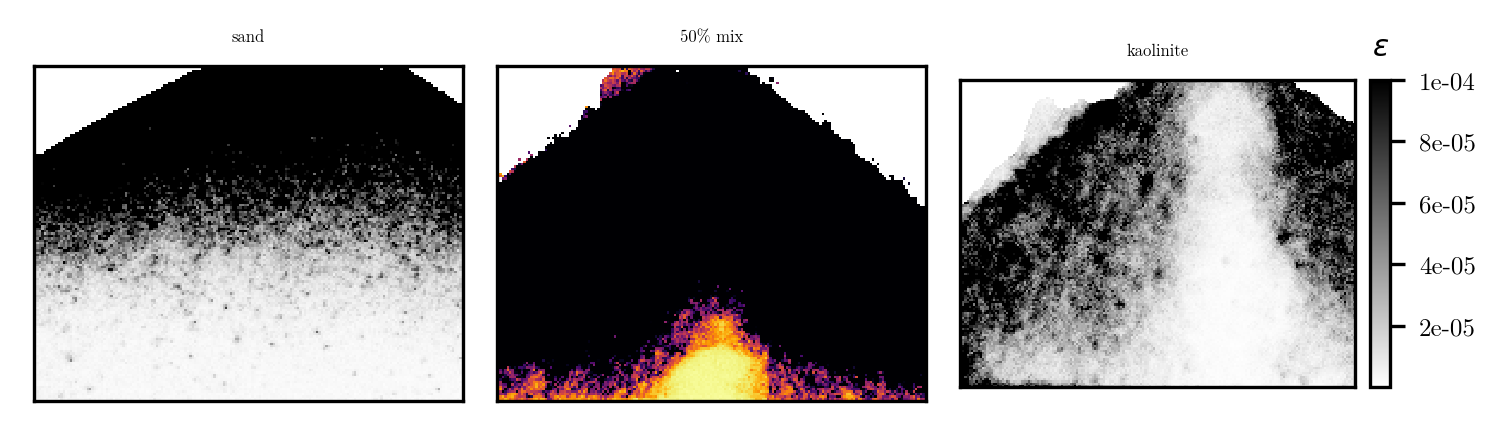

In [84]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
t = 1

fig = plt.figure(figsize=(5, 2))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

# fig.suptitle('heating test - 10 cycles')
#################################################################################################################
sand = correlation_sand[t][1]
sand[sand <= 0] = 1e-32
sand_mask = ma.masked_array(sand, mask=mask_sand)
sand_mask = -(np.log(sand_mask)/c) 

im1 = ax1.imshow(sand_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
ax1.set_title('sand',fontsize = 4)
ax1.set_xticks([])
ax1.set_yticks([])

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
# cax.set_title('$\epsilon$')

#################################################################################################################
mix = correlation_mix[t][1]
mix[mix <= 0] = 1e-32
mix_mask = ma.masked_array(mix, mask=mask_mix)
mix_mask = -(np.log(mix_mask)/c) 

im2 = ax2.imshow(mix_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'inferno_r')
ax2.set_title('50% mix',fontsize = 4)
ax2.set_xticks([])
ax2.set_yticks([])

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
# cax.set_title('$\epsilon$')
#################################################################################################################
kaolinite = correlation_kaolinite[t][1]
kaolinite[kaolinite <= 0] = 1e-32
kaolinite_mask = ma.masked_array(kaolinite, mask=mask_kaolinite)
kaolinite_mask = -(np.log(kaolinite_mask)/c) 

im3 = ax3.imshow(kaolinite_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
ax3.set_title('kaolinite',fontsize = 4)
ax3.set_xticks([])
ax3.set_yticks([])

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')


plt.tight_layout()

# plt.savefig('heating_tapping.png')

/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in less_equal
/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in less_equal
/home/ndeshpande/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in less_equal


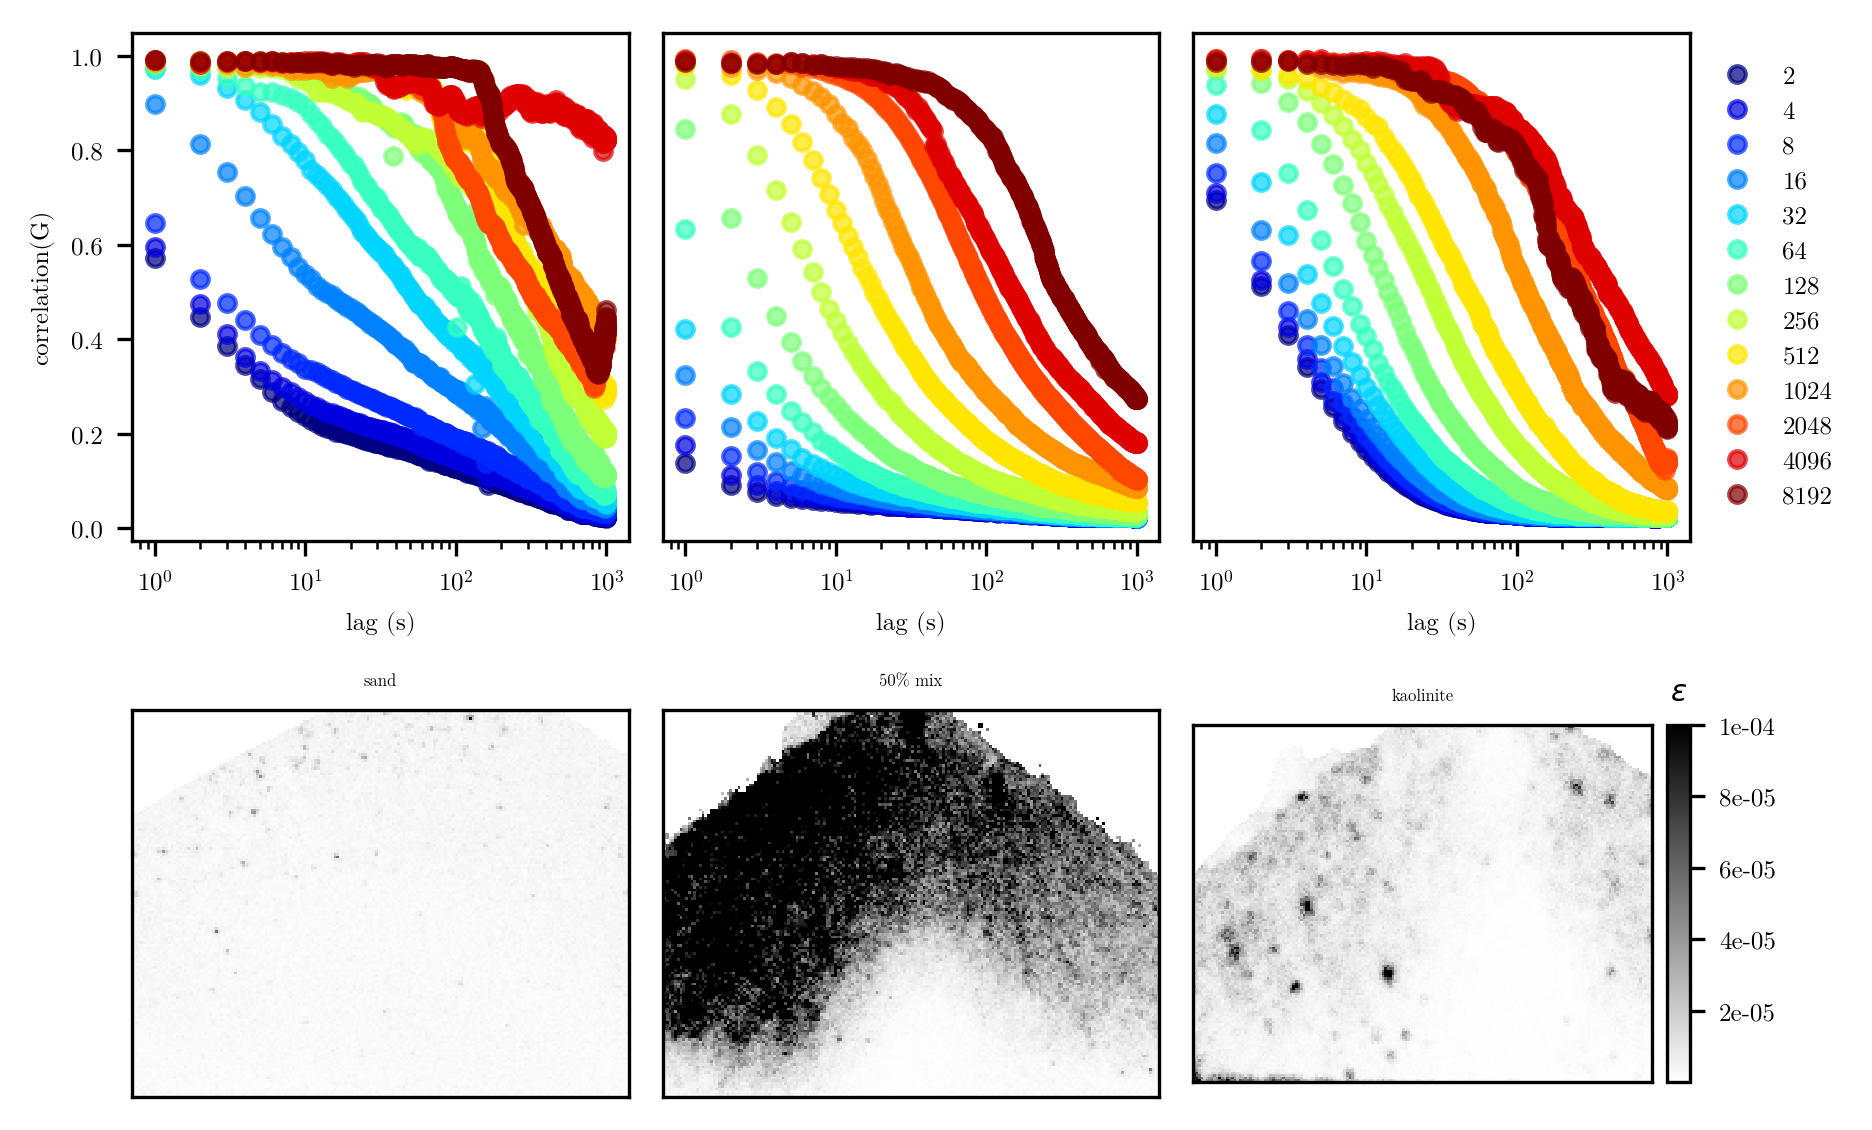

In [98]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
t = 1

fig = plt.figure(figsize=(6, 4))



ax1 = plt.subplot(2, 3, 1)
ax2 = plt.subplot(2, 3, 2)
ax3 = plt.subplot(2, 3, 3)

# fig.suptitle('heating test - 10 cycles')
#################################################################################################################
color=iter(cm.jet(np.linspace(0,1,13)))

for t in range(13):
    c=next(color)
    ax1.plot(means_sand[t],'o',color = c,markersize = 4,alpha = 0.7,label = int(labels[t]))

ax1.set_xscale('log')
ax1.set_xlabel('lag (s)')
ax1.set_ylabel('correlation(G)')

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
# cax.set_title('$\epsilon$')

#################################################################################################################
color=iter(cm.jet(np.linspace(0,1,13)))

for t in range(13):
    c=next(color)
    ax2.plot(means_mix[t],'o',color = c,markersize = 4,alpha = 0.7)#,label = int(labels[t]))

ax2.set_yticks([])
ax2.set_xscale('log')
ax2.set_xlabel('lag (s)')

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
# cax.set_title('$\epsilon$')
#################################################################################################################
color=iter(cm.jet(np.linspace(0,1,13)))

labels = list(np.logspace(1, 13, num=13, base=2))

for t in range(13):
    c=next(color)
    ax3.plot(means_kaolinite[t],'o',color = c,markersize = 4,alpha = 0.7,label = int(labels[t]))

ax3.legend()
ax3.set_yticks([])
ax3.set_xscale('log')
ax3.set_xlabel('lag (s)')


box = ax3.get_position()
lgd = ax3.legend()
ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax3.legend(loc='center left', frameon = False, bbox_to_anchor=(1, 0.5))

#################################################################################################################
from mpl_toolkits.axes_grid1 import make_axes_locatable
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
t = 5

ax4 = plt.subplot(2, 3, 4)
ax5 = plt.subplot(2, 3, 5)
ax6 = plt.subplot(2, 3, 6)

# fig.suptitle('heating test - 10 cycles')
#################################################################################################################
sand = correlation_sand[t][1]
sand[sand <= 0] = 1e-32
sand_mask = ma.masked_array(sand, mask=mask_sand)
sand_mask = -(np.log(sand_mask)/c) 

im4 = ax4.imshow(sand_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
ax4.set_title('sand',fontsize = 4)
ax4.set_xticks([])
ax4.set_yticks([])

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
# cax.set_title('$\epsilon$')

#################################################################################################################
mix = correlation_mix[t][1]
mix[mix <= 0] = 1e-32
mix_mask = ma.masked_array(mix, mask=mask_mix)
mix_mask = -(np.log(mix_mask)/c) 

im5 = ax5.imshow(mix_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
ax5.set_title('50% mix',fontsize = 4)
ax5.set_xticks([])
ax5.set_yticks([])

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
# cax.set_title('$\epsilon$')
#################################################################################################################
kaolinite = correlation_kaolinite[t][1]
kaolinite[kaolinite <= 0] = 1e-32
kaolinite_mask = ma.masked_array(kaolinite, mask=mask_kaolinite)
kaolinite_mask = -(np.log(kaolinite_mask)/c) 

im6 = ax6.imshow(kaolinite_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
ax6.set_title('kaolinite',fontsize = 4)
ax6.set_xticks([])
ax6.set_yticks([])

divider = make_axes_locatable(ax6)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im6, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')


plt.tight_layout()

plt.savefig('material_maps_relaxation.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

### Movie frames

In [ ]:
n = 0
fig = plt.figure(figsize=(4, 4))


for t in range(160):
    ax1 = plt.subplot(3, 1, 1)
    ax2 = plt.subplot(3, 1, 3)
    ax3 = plt.subplot(3, 1, 2)

    #################################################################################################################
    sand = correlation_sand[t][1]
    sand[sand <= 0] = 1e-32
    sand_mask = ma.masked_array(sand, mask=mask_sand)
    sand_mask = -(np.log(sand_mask)/c) 

    im1 = ax1.imshow(sand_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
    ax1.set_title('sand',fontsize = 4)
    ax1.set_xticks([])
    ax1.set_yticks([])

    # divider = make_axes_locatable(ax1)
    # cax = divider.append_axes('right', size='5%', pad=0.05)
    # fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
    # cax.set_title('$\epsilon$')

    #################################################################################################################
    mix = correlation_mix[t][1]
    mix[mix <= 0] = 1e-32
    mix_mask = ma.masked_array(mix, mask=mask_mix)
    mix_mask = -(np.log(mix_mask)/c) 

    im2 = ax2.imshow(mix_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
    ax2.set_title('50% mix',fontsize = 4)
    ax2.set_xticks([])
    ax2.set_yticks([])

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
    cax.set_title('$\epsilon$')
    #################################################################################################################
    kaolinite = correlation_kaolinite[t][1]
    kaolinite[kaolinite <= 0] = 1e-32
    kaolinite_mask = ma.masked_array(kaolinite, mask=mask_kaolinite)
    kaolinite_mask = -(np.log(kaolinite_mask)/c) 

    im3 = ax3.imshow(kaolinite_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
    ax3.set_title('kaolinite',fontsize = 4)
    ax3.set_xticks([])
    ax3.set_yticks([])

#     divider = make_axes_locatable(ax3)
#     cax = divider.append_axes('right', size='5%', pad=0.05)
#     fig.colorbar(im3, cax=cax, orientation='vertical',format='%.0e')
#     cax.set_title('$\epsilon$')


    plt.tight_layout()
    plt.savefig("test" + str(n) +".png", format="PNG")
    plt.clf()
    n += 1


## Heating: Cycles

In [ ]:
import glob
import natsort

image_names = []

for name in glob.glob('/media/ndeshpande/My Passport/data/Hillslope_DWS/heating/A/img_*.jpg'):
    image_names.append(name)

image_names = natsort.natsorted(image_names,reverse=False)
timestep = len(image_names)

### Creating masks

In [ ]:
#specify the bounds of the image - should be evenly divisible by the metapixel size
x_min = 0
x_max = 1800
y_min = 0
y_max = 1400

# choosing two speckle images
speckle_a = Image.open(image_names[50])
speckle_a = np.asarray(speckle_a)[y_min:y_max,x_min:x_max]

speckle_b = Image.open(image_names[60])
speckle_b = np.asarray(speckle_b)[y_min:y_max,x_min:x_max]
    
# partitioning images into metpixels
size = 10
a = speckle_a
lenr, lenc = int(a.shape[0]/size), int(a.shape[1]/size)
## 'flattening' the metapixel array along a single axis
metapixels_a = speckle_a.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)

b = speckle_b
lenr, lenc = int(b.shape[0]/size), int(b.shape[1]/size)
metapixels_b = speckle_b.reshape(lenr,size,lenc,size).transpose(0, 2, 1, 3)
    
metapixel_grid_rows = metapixels_a.shape[0]
metapixel_grid_columns = metapixels_a.shape[1]
metapixel_grid_area = metapixel_grid_rows*metapixel_grid_columns

In [ ]:
mp_a_mean = np.mean(metapixels_a,axis = (2,3))
mp_b_mean = np.mean(metapixels_b,axis = (2,3))

## Adding [...,np.newaxis,np.newaxis] allows the array of means to be subtracted
## from the array containing metapixels. otherwise, their shapes are not the same
metapixels_a = np.subtract(metapixels_a,mp_a_mean[..., np.newaxis,np.newaxis])
metapixels_b = np.subtract(metapixels_b,mp_b_mean[..., np.newaxis,np.newaxis])

In [ ]:
from skimage.filters import try_all_threshold

img = mp_a_mean

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [ ]:
from skimage.filters import threshold_otsu
image = mp_a_mean
thresh = threshold_otsu(image)
binary = image > thresh
mask_heating_cycles = ~binary

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

### Calculating G

In [ ]:
# time = np.logspace(1, 13, num=13, base=2)
# time = (0,10,25,50,100,250,500)
time = np.arange (0,160,1)

correlation_heat_cycles, means_heat_cycles = Calculate_G(image_names,286,time,2)

### 2d maps

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
t = 40

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 4))
ax1 = plt.subplot(1, 1, 1)
# ax2 = plt.subplot(1, 2, 2)

a = correlation_heat_cycles[t][1]
a[a <= 0] = 1e-32

masked_map = ma.masked_array(a, mask=~binary)

masked_map = -(np.log(masked_map)/c) 

im1 = ax1.imshow(masked_map,vmin = 1e-7,vmax = 1e-4,cmap = 'gray_r')

cmap = plt.cm.gray_r
cmap.set_bad('white',1.)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')
# cax.tick_params(labelsize=15) 
cax.set_title('$\epsilon$')#,fontsize = 15)

# ax1.set_title('t = 16 s, τ = 1')#,fontsize = 20);
# ax1.set_xlim([30,175]);
ax1.set_xticks([]);
ax1.set_yticks([]);

## Ensemble Disturbance maps

In [ ]:
t = 60

In [ ]:
fig = plt.figure(figsize=(4, 4))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

# fig.suptitle('heating test - 10 cycles')
#################################################################################################################
heat = correlation_heat_cycles[t][1]
heat[heat <= 0] = 1e-32
heat_mask = ma.masked_array(heat, mask=mask_heating_cycles)
heat_mask = -(np.log(heat_mask)/c) 

im1 = ax1.imshow(heat_mask,cmap = 'gray_r',vmin = 1e-7, vmax = 1e-4)
ax1.set_title('heating',fontsize = 4)
ax1.set_xticks([])
ax1.set_yticks([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')

#################################################################################################################
tap = correlation_tapping_cycles[t][1]
tap[tap <= 0] = 1e-32
tap_mask = ma.masked_array(tap, mask=mask_tapping_cycles)
tap_mask = -(np.log(tap_mask)/c) 

im2 = ax2.imshow(tap_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
ax2.set_title('tapping',fontsize = 4)
ax2.set_xticks([])
ax2.set_yticks([])

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')


plt.tight_layout()

# plt.savefig('heating_tapping.png')

## Ensemble multicycle disturbance movies

In [ ]:
n = 0
fig = plt.figure(figsize=(4, 4))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)


for t in range(160):
    ax1 = plt.subplot(2, 1, 1)
    ax2 = plt.subplot(2, 1, 2)

    #################################################################################################################
    heat = correlation_heat_cycles[t][1]
    heat[heat <= 0] = 1e-32
    heat_mask = ma.masked_array(heat, mask=mask_heating_cycles)
    heat_mask = -(np.log(heat_mask)/c) 

    im1 = ax1.imshow(heat_mask,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
    ax1.set_title('heating',fontsize = 4)
    ax1.set_xticks([])
    ax1.set_yticks([])

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
    cax.set_title('$\epsilon$')

    #################################################################################################################
    tap = correlation_tapping_cycles[t][1]
    tap[tap <= 0] = 1e-32
    tap_mask = ma.masked_array(tap, mask=mask_tapping_cycles)
    tap_mask = -(np.log(tap_mask)/c) 

    im2 = ax2.imshow(tap_mask,vmin = 1e-7, vmax = 1e-5, cmap = 'gray_r')
    ax2.set_title('tapping',fontsize = 4)
    ax2.set_xticks([])
    ax2.set_yticks([])

    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
    cax.set_title('$\epsilon$')


    plt.tight_layout()
    
    plt.savefig("ensmble_test" + str(n) +".png", format="PNG")
    plt.clf()
    n += 1

# Profiles

Images from experiments are acquired from a level perspective - in order to measure surface-normal velocity/strain profiles, the images must be rotated by the angle of repose and cropped to a region of interest.

## Rotating images

In [ ]:
from skimage import transform

a = correlation[4][1]
a[a <= 0] = 0

masked_map = ma.masked_array(a, mask=mask)
img = masked_map
mask = mask 

y_min = 40
y_max = 90
x_min = 32
x_max = 110
rotation_angle = -29


rotated_test = transform.rotate(img,rotation_angle,preserve_range = True,resize = True)
rotated_mask = transform.rotate(mask,rotation_angle,preserve_range = True,resize = True)
rotated_masked_image = ma.masked_array(rotated_test,mask = rotated_mask) 

roi_verts = [[y_max,x_max],[y_min,x_max],[y_min, x_min], [y_max, x_min]]
roi_verts.append(roi_verts[0])
x_roi, y_roi = zip(*roi_verts) 


cropped_rows = rotated_test[y_min:y_max,x_min:x_max].shape[0]

plt.subplot(1,3,1)
plt.imshow(img,vmin = .9,vmax = 1,cmap = 'gray')
# plt.fill(x1,y1,'w',alpha = 1,edgecolor = 'k') 
plt.xlim([0,180])

plt.title('unrotated image')
plt.subplot(1,3,2)
plt.imshow(rotated_masked_image,vmin = .9,vmax = 1,cmap = 'gray')
plt.fill(y_roi,x_roi,'w',alpha = .3,edgecolor = 'k') 
plt.axis('scaled')
plt.title('rotated image')

plt.subplot(1,3,3)
plt.imshow(rotated_test[y_min:y_max,x_min:x_max],vmin = .9,vmax = 1,cmap = 'gray')
plt.title('cropped and rotated image image')
# plt.tight_layout()


# plt.savefig('profile_protocol.png')

## Computing depth-averaged quantities

In [ ]:
def depth_average(correlation_map):
    x = len(correlation_map)
    timestep = len(correlation_map)
    
    G_mean_depth_averaged = [[] for _ in range(x)]
    G_var_depth_averaged = [[] for _ in range(x)]
    
    ROI_average = []
    ROI_var = []
    
    # deformation [time][row][column]
    for t in range(timestep-1):
        
        G_map_temp = correlation_map[t]
        G_map_rotated = transform.rotate(G_map_temp,rotation_angle,preserve_range = True,resize = True)
        G_map_cropped = np.asarray(G_map_rotated[y_min:y_max,x_min:x_max])
        
        cropped_rows = G_map_cropped.shape[0]
        cropped_columns = G_map_cropped.shape[1]
        cropped_area = cropped_rows*cropped_columns
        
        ROI_average.append(np.nanmean(G_map_cropped))
        ROI_var.append(np.nanvar(G_map_cropped))
        
        G_mean_temp = []
        G_var_temp = []
        
        for i in range(cropped_rows):
            G_mean_temp.append(np.nanmean(G_map_cropped[i][:]))
            G_var_temp.append(np.nanvar(G_map_cropped[i][:]))
            
        G_mean_depth_averaged[t] = G_mean_temp
        G_var_depth_averaged[t] = G_var_temp
        
        del G_map_temp,G_map_rotated,G_map_cropped,G_mean_temp,G_var_temp

    return G_mean_depth_averaged,G_var_depth_averaged,ROI_average,ROI_var

In [ ]:
mean_depth_avg,var_depth_avg,ROI_mean,ROI_var = depth_average(correlation[50])

## Creating variables to correctly scale depth

In [ ]:
# this is the depth, in metapixels
z = np.arange(1,(y_max-y_min)+1,1)
#depth in pixels
z = z*10
#depth in meters
z = z*3.6e-5
#depth normalized by grainsize
# z = z/100e-6
# z = z/np.max(z)

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
D1 = -(np.log(np.asarray(mean_depth_avg[1]))/c) 
D2 = -(np.log(np.asarray(mean_depth_avg[3]))/c) 
D3 = -(np.log(np.asarray(mean_depth_avg[5]))/c) 
# D4 = -(np.log(np.asarray(mean_depth_avg[4]))/c) 

In [ ]:
fig = plt.figure(figsize=(3,3))

plt.plot(D1,z,'yo',markersize = 5,markeredgecolor = 'k',label='τ = 0 s')
plt.plot(D2,z,'go',markersize = 5,markeredgecolor = 'k',label='τ = 1 s')
# plt.plot(D3,z,'bo',markersize = 5,markeredgecolor = 'k',label='τ = 10 s')
# plt.plot(D4,z,'ro',markersize = 5,markeredgecolor = 'k',label='τ = 20 s')


plt.gca().invert_yaxis()
# plt.xlim(1e-7,1e-5)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\epsilon$')
plt.ylabel('z (m)')
plt.legend()
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# plt.savefig('example_profile.png')

## Fitting with polyfit

In [ ]:
def fit(xdata,ydata):
    xdata = (abs(xdata))
    xdata = xdata/np.max(xdata)
    ydata = (abs(ydata))

    w = np.sqrt(ydata)
    
    m,b = np.polyfit(xdata,np.log(ydata), 1,w = w)
    y = m*xdata + b
    
    x_scaled = xdata*-m
    y_scaled = ydata/np.exp(b)
    
    #y_scaled = np.exp((y-b)/-m)
    return x_scaled, y_scaled

In [ ]:
x_fit1, y_fit1 = fit(z,D1)
x_fit2,y_fit2 = fit(z,D2)
x_fit3,y_fit3 = fit(z,D3)
x_fit4,y_fit4 = fit(z,D4)

In [ ]:
fig = plt.figure(figsize=(2,2))
plt.plot(x_fit1,y_fit1,'o',markersize = 5,markeredgecolor = 'k')
plt.plot(x_fit2,y_fit2,'o',markersize = 5,markeredgecolor = 'k')
plt.plot(x_fit3,y_fit3,'o',markersize = 5,markeredgecolor = 'k')
plt.plot(x_fit4,y_fit4,'o',markersize = 5,markeredgecolor = 'k')

# plt.xlabel('log z')
# plt.ylabel('log v')
plt.yscale('log')

In [ ]:
np.savez('dws_profile',data1 = x_fit4, data2 = y_fit4)

## Fitting with scipy.optimize

### Single exponential

In [ ]:
from scipy.optimize import curve_fit

def fit(xdata,ydata):
    def decay(x,A,λ,c):
        return  A*np.exp(x/-λ)+c

    parameters, parameterscov = curve_fit(decay, xdata, ydata)
    y_fit = decay(xdata,*parameters)
    
    #assessing goodness of fit
    residuals = ydata - decay(xdata,*parameters)
    ## residual sum of squares
    ss_res = np.sum(residuals**2)
    # total sum of squares
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared 
    
    return y_fit, parameters

In [ ]:
fit1, param1 = fit(z,D1)
fit2, param2 = fit(z,D2)
fit3, param3 = fit(z,D3)
fit4, param4 = fit(z,D4)

In [ ]:
fig = plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.plot(z,D1,'ro',markersize = 5,markeredgecolor = 'k',label='τ = 20 s')
plt.plot(z,D2,'go',markersize = 5,markeredgecolor = 'k',label='τ = 20 s')
plt.plot(z,D3,'bo',markersize = 5,markeredgecolor = 'k',label='τ = 20 s')
plt.plot(z,D4,'yo',markersize = 5,markeredgecolor = 'k',label='τ = 20 s')

plt.plot(z,fit1,'k',linewidth = 3,alpha = 0.7)
plt.plot(z,fit2,'k',linewidth = 3,alpha = 0.7)
plt.plot(z,fit3,'k',linewidth = 3,alpha = 0.7)
plt.plot(z,fit4,'k',linewidth = 3,alpha = 0.7)

# plt.yscale('log')
# plt.xscale('log')

plt.subplot(1,2,2)
plt.plot(z/param1[0],(D1/param1[1]),'ro',markersize = 5,markeredgecolor = 'k',label='τ = 20 s')
plt.plot(z/param2[0],(D2/param2[1]),'go',markersize = 5,markeredgecolor = 'k',label='τ = 20 s')
plt.plot(z/param3[0],(D3/param3[1]),'bo',markersize = 5,markeredgecolor = 'k',label='τ = 20 s')
plt.plot(z/param4[0],(D4/param4[1]),'yo',markersize = 5,markeredgecolor = 'k',label='τ = 20 s')

In [ ]:
x = z/param[1]
y = (D2/param[0])+param[2]

### Double exponential

In [ ]:
x_array = z
y_array = D4

popt_exponential, pcov_exponential = curve_fit(_2exponential, x_array, y_array)
y_fit = _2exponential(x_array,*popt_exponential)

In [ ]:
from scipy.optimize import curve_fit

def fit(xdata,ydata):
    def decay(x, a, k1, b, k2, c):
        return a*np.exp(x/-k1) + b*np.exp(x/-k2) + c

    parameters, parameterscov = curve_fit(decay, xdata, ydata)
    y_fit = decay(xdata,*parameters)
    
    #assessing goodness of fit
    residuals = ydata - decay(xdata,*parameters)
    ## residual sum of squares
    ss_res = np.sum(residuals**2)
    # total sum of squares
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    r_squared 
    
    return y_fit, parameters

In [ ]:
fit3, param3 = fit(z,D1)

In [ ]:
plt.plot(z,fit3)
plt.plot(z,D1,'ko')
plt.yscale('log')

## Ensemble velocity profiles in semilog space

In [ ]:
fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(3, 3, 1)
ax2 = plt.subplot(3, 3, 2)
ax3 = plt.subplot(3, 3, 3)
ax4 = plt.subplot(3, 3, 4)
ax5 = plt.subplot(3, 3, 5)
ax6 = plt.subplot(3, 3, 6)
ax7 = plt.subplot(3, 3, 7)
ax8 = plt.subplot(3, 3, 8)
ax9 = plt.subplot(3, 3, 9)

profile_1 = mean_depth_avg_1000_1100
profile_2 = mean_depth_avg_2000_2100
profile_3 = mean_depth_avg_3000_3100
profile_4 = mean_depth_avg_4000_4100
profile_5 = mean_depth_avg_5000_5100
profile_6 = mean_depth_avg_6000_6100
profile_7 = mean_depth_avg_7000_7100
profile_8 = mean_depth_avg_8000_8100
profile_9 = mean_depth_avg_9000_9100

t_1 = 30
t_2 = 40
t_3 = 50
t_4 = 60
t_5 = 50

ax1.plot(z,profile_1[t_1],'ro',markersize = 2.5,label = 't = 10')
ax1.plot(z,profile_1[t_2],'mo',markersize = 2.5,label = 't = 13')
ax1.plot(z,profile_1[t_3],'yo',markersize = 2.5,label = 't = 15')
ax1.plot(z,profile_1[t_4],'go',markersize = 2.5,label = 't = 20')
ax1.set_title('t 1000-1100')
ax1.set_ylabel('$\epsilon$')
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax1.set_yscale('log')
ax1.set_xticks([])

ax2.plot(z,profile_2[t_1],'ro',markersize = 2.5,label = 't = 10')
ax2.plot(z,profile_2[t_2],'mo',markersize = 2.5,label = 't = 13')
ax2.plot(z,profile_2[t_3],'yo',markersize = 2.5,label = 't = 15')
ax2.plot(z,profile_2[t_4],'go',markersize = 2.5,label = 't = 20')
ax2.set_title('t 2000-2100')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax2.set_yscale('log')
ax2.set_xticks([])


ax3.plot(z,profile_3[t_1],'ro',markersize = 2.5,label = 't = 10')
ax3.plot(z,profile_3[t_2],'mo',markersize = 2.5,label = 't = 13')
ax3.plot(z,profile_3[t_3],'yo',markersize = 2.5,label = 't = 15')
ax3.plot(z,profile_3[t_4],'go',markersize = 2.5,label = 't = 20')
ax3.set_title('t 3000-3100')
ax3.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax3.set_yscale('log')
ax3.set_xticks([])


ax4.plot(z,profile_4[t_1],'ro',markersize = 2.5,label = 't = 10')
ax4.plot(z,profile_4[t_2],'mo',markersize = 2.5,label = 't = 13')
ax4.plot(z,profile_4[t_3],'yo',markersize = 2.5,label = 't = 15')
ax4.plot(z,profile_4[t_4],'go',markersize = 2.5,label = 't = 20')
ax4.set_title('t 4000-4100')
ax4.set_ylabel('$\epsilon$')
ax4.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax4.set_yscale('log')
ax4.set_xticks([])


ax5.plot(z,profile_5[t_1],'ro',markersize = 2.5,label = 't = 10')
ax5.plot(z,profile_5[t_2],'mo',markersize = 2.5,label = 't = 13')
ax5.plot(z,profile_5[t_3],'yo',markersize = 2.5,label = 't = 15')
ax5.plot(z,profile_5[t_4],'go',markersize = 2.5,label = 't = 20')
ax5.set_title('t 5000-5100')
ax5.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax5.set_yscale('log')
ax5.set_xticks([])


ax6.plot(z,profile_6[t_1],'ro',markersize = 2.5,label = 't = 10')
ax6.plot(z,profile_6[t_2],'mo',markersize = 2.5,label = 't = 13')
ax6.plot(z,profile_6[t_3],'yo',markersize = 2.5,label = 't = 15')
ax6.plot(z,profile_6[t_4],'go',markersize = 2.5,label = 't = 20')
ax6.set_title('t 6000-6100')
ax6.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax6.set_yscale('log')
ax6.set_xticks([])


ax7.plot(z,profile_7[t_1],'ro',markersize = 2.5,label = 't = 10')
ax7.plot(z,profile_7[t_2],'mo',markersize = 2.5,label = 't = 13')
ax7.plot(z,profile_7[t_3],'yo',markersize = 2.5,label = 't = 15')
ax7.plot(z,profile_7[t_4],'go',markersize = 2.5,label = 't = 20')
ax7.set_title('t 7000-7100')
ax7.set_ylabel('$\epsilon$')
ax7.set_xlabel('z/d')
ax7.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax7.set_yscale('log')

ax8.plot(z,profile_8[t_1],'ro',markersize = 2.5,label = 't = 10')
ax8.plot(z,profile_8[t_2],'mo',markersize = 2.5,label = 't = 13')
ax8.plot(z,profile_8[t_3],'yo',markersize = 2.5,label = 't = 15')
ax8.plot(z,profile_8[t_4],'go',markersize = 2.5,label = 't = 20')
ax8.set_title('t 8000-8100')
ax8.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax8.set_xlabel('z/d')
ax8.set_yscale('log')

ax9.plot(z,profile_9[t_1],'ro',markersize = 2.5,label = 't = 30')
ax9.plot(z,profile_9[t_2],'mo',markersize = 2.5,label = 't = 40')
ax9.plot(z,profile_9[t_3],'yo',markersize = 2.5,label = 't = 50')
ax9.plot(z,profile_9[t_4],'go',markersize = 2.5,label = 't = 60')
ax9.set_title('t 9000-9100')
ax9.set_xlabel('z/d')
ax9.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax9.set_yscale('log')
ax9.legend()


plt.tight_layout()

# plt.savefig('velocity_profiles_ensemble_growing_lags')

## Prototyping curve fitting

### Writing my own stretched-exponential fit

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def stretched_exponential_betafixed(x, A , τ):
    return  A*np.exp(-x / τ)**3/2

def stretched_exponential_betafree(x, A , τ, beta):
    return  A*np.exp(-x / τ)**beta

In [ ]:
fig = plt.figure(figsize=(6, 2))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)


xdata = np.arange(1, 999, 1)

ydata = gp[10] 

parameters_betafixed, parameterscov_betafixed = curve_fit(stretched_exponential_betafixed, xdata, ydata)#, bounds=(0,1))

y_fit = stretched_exponential_betafixed(xdata,*parameters_betafixed)


ax1.plot(xdata,ydata,'ko',alpha = 0.7, markersize = 2,label = 'observations')
ax1.plot(xdata,y_fit,'ro',alpha = 0.7, markersize = 2,label = 'fit')
ax1.set_xscale('log')
# ax1.set_yscale('log')
ax1.set_ylim([0,1.2])
ax1.set_xlabel('time')
ax1.set_ylabel('G')
ax1.set_title('observations vs. fit')
ax1.legend()

ax2.plot(xdata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)
ax2.set_title('residuals')
ax2.set_ylabel('residuals (G_observed vs. G_fitted)')
ax2.set_xlabel('time')


ax3.plot(ydata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)
ax2.set_title('G_observed vs. residuals')
ax3.set_xlabel('G_observed')
ax3.set_ylabel('residuals')


plt.tight_layout()

# plt.savefig('residuals_analysis.png')

In [ ]:
# plt.plot(xdata,y_fit)
plt.plot(xdata,ydata,'ko',alpha = 0.7, markersize = 2,label = 'observations')
plt.xscale('log')
plt.yscale('log')

In [ ]:
fig = plt.figure(figsize=(6, 2))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)


xdata = np.arange(1, 101, 1)

ydata = gp[10] 

parameters_betafree, parameterscov_betafree = curve_fit(stretched_exponential_betafree, xdata, ydata)#, bounds=(0,1))

y_fit = stretched_exponential_betafree(xdata,*parameters_betafree)

ax1.plot(xdata,ydata,'ko',alpha = 0.7, markersize = 2,label = 'observations')
ax1.plot(xdata,y_fit,'ro',alpha = 0.7, markersize = 2,label = 'fit')
ax1.set_xscale('log')
ax1.set_xlabel('time')
ax1.set_ylabel('G')
ax1.set_title('observations vs. fit')
ax1.legend()


ax2.plot(xdata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)

ax3.plot(ydata,ydata-y_fit,'ko',alpha = 0.7, markersize = 2)

plt.tight_layout()

Assessing the goodness of fit from the outputs of scipy_optimize.

In [ ]:
residuals = ydata - stretched_exponential_betafixed(xdata,*popt)
## residual sum of squares
ss_res = np.sum(residuals**2)
# total sum of squares
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared 

## A loop to automate fitting and parameter extraction

first, just a loop to plot the data and the fit with a subplot for comparisons

In [ ]:
xdata = np.arange(1, 999, 1)
n = 12
yfits = [[] for _ in range(n)]
ydata = [[] for _ in range(n)]

for i in range(n):
    ydata[i] = gp[i] 
    parameters_betafixed, parameterscov_betafixed = curve_fit(stretched_exponential_betafixed, xdata, ydata[i])#, bounds=(0,1))
    yfits[i] = stretched_exponential_betafixed(xdata,*parameters_betafixed)

Comparing fits vs. data

In [ ]:
# fig = plt.figure(figsize=(6, 4))
ax1 = plt.subplot(3, 2, 1)
ax2 = plt.subplot(3, 2, 2)
ax3 = plt.subplot(3, 2, 3)
ax4 = plt.subplot(3, 2, 4)
ax5 = plt.subplot(3, 2, 5)
ax6 = plt.subplot(3, 2, 6)

ax1.plot(yfits[0],'k')
ax1.plot(ydata[0])
ax1.set_xscale('log')
ax1.set_xticks([])

ax3.plot(yfits[2])
ax3.plot(ydata[2])
ax3.set_xscale('log')
ax3.set_xticks([])

ax5.plot(yfits[6])
ax5.plot(ydata[6])
ax5.set_xscale('log')

ax2.plot(yfits[8])
ax2.plot(ydata[8])
ax2.set_xscale('log')
ax2.set_xticks([])

ax4.plot(yfits[10])
ax4.plot(ydata[10])
ax4.set_xscale('log')
ax4.set_xticks([])

ax6.plot(yfits[11])
ax6.plot(ydata[11])
ax6.set_xscale('log')

# plt.savefig('fits_betafree.png')

This loop cycles through the correlation function for the calculated start times and fits a stretched exponential to the data. Stored in the variable "fitting_parameters" are the fitted values and the covariance of each (see scipy_optimize for more information).

"fitting_parameters" is a nested list with dimensions

[start time] [popt,popcov] [τ]

In [ ]:
fitting_parameters = [[] for _ in range(n)]
ydata = [[] for _ in range(n)]

for i in range(n):    
    ydata[i] = gp[i] 
    popt, pcov = curve_fit(stretched_exponential_betafixed, xdata, ydata[i])#, bounds=(0,1))
    
    fitting_parameters[i] = popt, pcov

Plotting the decay rate  τ as a function of time.

In [ ]:
tau = []
A = []
beta = []
for i in range(n):
    A.append(fitting_parameters[i][0][0])
    tau.append(fitting_parameters[i][0][1])
#     beta.append(fitting_parameters[i][0][2])

In [ ]:
fig = plt.figure(figsize=(3, 3))
t = np.arange(1, 101, 1)
# t = np.logspace(1, 13, num=13, base=2)
color=iter(cm.viridis(np.linspace(0,1,n)))

for i in range(n):
    c=next(color)
    plt.plot(t[i],tau[i],'o',color = c,markeredgecolor='k',markersize = 8)
# plt.plot(t,sqrt_t,'o')   
# plt.plot(x,y)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('start time (s)',fontsize = 8)
# plt.axis('square')
plt.ylabel('τ',fontsize = 15);
plt.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()

# plt.savefig('decaytime.png')

In [ ]:
tau_hot[20]

In [ ]:
tau_hot = tau
gp_hot = gp

In [ ]:
fig = plt.figure(figsize=(2, 2))
n = 10
t_hot = np.arange(1, 101,1)
t = np.arange(1, 999,1)
color1=iter(cm.jet_r(np.linspace(0,1,n)))
color2=iter(cm.gray_r(np.linspace(0,1,n)))


for i in reversed(range(n)):
    c1=next(color1)
    c2=next(color2)
    plt.plot(t/tau[i],gp[i],'o',color = c1,markersize = 4,alpha =.8)
    plt.plot(t_hot/tau_hot[i],gp_hot[i],'o',color = c2,markersize = 4,alpha =.8)

    

    
    
# plt.plot(x,power,'k')
plt.xscale('log')xxxx
# plt.yscale('log')
plt.xlabel('start time (s)')
plt.ylabel('τ (decay time - from fit)');

# plt.savefig('decaytime.png')

# Mapping G to strain

In [ ]:
l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
G_synthetic = np.arange(0.1,1,.01)
D_synthetic = -(np.log(G_synthetic)/c) 
plt.plot(G_synthetic,D_synthetic)

plt.xlabel('G (decorrelation)')
plt.ylabel('D (strain)')

# Generating master figures

## Ensemble maps

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(4, 4))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
##################################################################################################################
# fig.suptitle('heating test - 10 cycles')
a = G_purecreep_B[11][100]
a[a <= 0] = .000001
masked_map = ma.masked_array( -(np.log(np.asarray(a))/c), mask=mask)

im1 = ax1.imshow(masked_map,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
ax1.set_title('A',fontsize = 8)
ax1.set_xticks([])
ax1.set_yticks([])

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')
##################################################################################################################
# fig.suptitle('heating test - 10 cycles')
a = G_purecreep_B[11][200]
a[a <= 0] = .000001
a = -(np.log(np.asarray(a))/c)
masked_map = ma.masked_array(a , mask=mask)

im2 = ax2.imshow(masked_map,vmin = 1e-7, vmax = 1e-4, cmap = 'gray_r')
ax2.set_title('B',fontsize = 8)
ax2.set_xticks([])
ax2.set_yticks([])

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')


plt.tight_layout()

# plt.savefig('heating_tapping.png')

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8, 4))

# fig.suptitle('t 9000 -> 9100')

D = -(np.log(np.asarray(mean_depth_avg[10]))/c) 

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1,rowspan = 2)

ax1.plot(-(np.log(np.asarray(mean_depth_avg[0]))/c) ,z,'ro',markersize = 2.5,label = 't = 501')
ax1.plot(-(np.log(np.asarray(mean_depth_avg[1]))/c) ,z,'mo',markersize = 2.5,label = 't = 505')
ax1.plot(-(np.log(np.asarray(mean_depth_avg[4]))/c) ,z,'yo',markersize = 2.5,label = 't = 550')
ax1.plot(-(np.log(np.asarray(mean_depth_avg[5]))/c) ,z,'go',markersize = 2.5,label = 't = 590')

ax1.set_xlabel('$\epsilon$')
ax1.set_ylabel('z (m)')
ax1.invert_yaxis()
# ax1.set_xlim([-1e-4,1e-5])
ax1.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

plt.legend(frameon = False)

# plt.xscale('log')
# plt.yscale('log')
##################################################################################################################
a = G_purecreep_B[4][1]
a[a <= 0] = 0
masked_map = ma.masked_array(a, mask=mask)

ax2 = plt.subplot2grid((3, 3), (0, 1), rowspan=1,colspan = 1)
im2 = ax2.imshow(masked_map,vmin = 1e-7,vmax = 1e-4,cmap='gray_r')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')

ax2.fill(x1,y1,'k',alpha = 1,edgecolor = 'k') 
ax2.set_title('t = 1')
ax2.set_xlim(0,180)
ax2.set_xticks([])
ax2.set_yticks([])
##################################################################################################################
ax3 = plt.subplot2grid((3, 3), (0, 2), rowspan=1,colspan = 1)
im3 = ax3.imshow(spatial_map_500_600[5],vmin = 1e-7,vmax = 1e-4,cmap='gray_r')

divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')

ax3.fill(x1,y1,'k',alpha = 1,edgecolor = 'k') 
ax3.set_title('t = 3')
ax3.set_xlim(0,180)
ax3.set_xticks([])
ax3.set_yticks([])
##################################################################################################################
ax4 = plt.subplot2grid((3, 3), (1, 1), rowspan=1,colspan = 1)
im4 = ax4.imshow(spatial_map_500_600[20],vmin = 1e-7,vmax = 1e-4,cmap='gray_r')

divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')

ax4.fill(x1,y1,'k',alpha = 1,edgecolor = 'k') 
ax4.set_title('t = 20')
ax4.set_xlim(0,180)
ax4.set_xticks([])
ax4.set_yticks([])
##################################################################################################################
ax5 = plt.subplot2grid((3, 3), (1, 2), rowspan=1,colspan = 1)
im5 = ax5.imshow(spatial_map_500_600[90],vmin = 1e-7,vmax = 1e-4,cmap='gray_r')

divider = make_axes_locatable(ax5)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im5, cax=cax, orientation='vertical',format='%.0e')
cax.set_title('$\epsilon$')

ax5.fill(x1,y1,'k',alpha = 1,edgecolor = 'k') 
ax5.set_title('t = 90')
ax5.set_xlim(0,180)
ax5.set_xticks([])
ax5.set_yticks([])

plt.tight_layout()

# plt.savefig('ensemble_test.pdf')

In [ ]:
mask = np.load('/home/ndeshpande/Documents/Python Scripts/DWS_Speckle_Analysis/mask_b.npz')
mask = mask['data1']

cmap = plt.cm.gray
cmap.set_bad('black',1.)
masked_map = ma.masked_array(G_purecreep_B[0][1],mask = mask)

plt.imshow(masked_map,vmin = 0,vmax = 1,cmap = 'viridis_r')
plt.xticks([])
plt.yticks([]);

# Sensitivity of relaxation functions to metapixel size

Generate the G vs. lag data for images split into metapixel sizes of: 2, 5, 10, 20 and 50 (numbers easily divisible by the dimensions of the cropped image) and formally compare them. 

I don't think its necessary to do this metapixel sensitivity thing for all lags, or profiles/other quantities. The correlation function is the root of it all so demonstrating it in this space should be sufficient. 

However, it might be useful to extend this comparison when the data are fitted to see if there is a control on the box size on the fit. 

I did a comparison of this before with lag times of 10 seconds instead of 1 second. (I should repeat it here with the new code and this general sensitivity section). The correlation function was smoother - but therer were still large bumps. Doing a test in time will also be useful. I.E. explore the sensitivity in space and time. 

In [ ]:
purecreep_A_relaxation_5px = np.load('/media/ndeshpande/My Passport/data/Hillslope_DWS/pure_creep/data_products/metapixel_sensitivity/purecreep_A_0_8000_1000lags_metapixels_5.npz')
purecreep_A_relaxation_5px = purecreep_A_relaxation_5px['data1']

purecreep_A_relaxation_10px = np.load('/media/ndeshpande/My Passport/data/Hillslope_DWS/pure_creep/data_products/metapixel_sensitivity/purecreep_A_0_8000_1000lags_metapixels_10.npz')
purecreep_A_relaxation_10px = purecreep_A_relaxation_10px['data1']

purecreep_A_relaxation_20px = np.load('/media/ndeshpande/My Passport/data/Hillslope_DWS/pure_creep/data_products/metapixel_sensitivity/purecreep_A_0_8000_1000lags_metapixels_20.npz')
purecreep_A_relaxation_20px = purecreep_A_relaxation_20px['data1']

purecreep_A_relaxation_50px = np.load('/media/ndeshpande/My Passport/data/Hillslope_DWS/pure_creep/data_products/metapixel_sensitivity/purecreep_A_0_8000_1000lags_metapixels_50.npz')
purecreep_A_relaxation_50px = purecreep_A_relaxation_50px['data1']

In [ ]:
fig = plt.figure(figsize=(4, 4))


color=iter(cm.viridis(np.linspace(0,1,13)))


plt.subplot(2,2,1)
for i in range(len(purecreep_A_relaxation_5px)):
    c=next(color)
    plt.plot(purecreep_A_relaxation_5px[i],'o',color = c,markersize = 2)
plt.xscale('log')
plt.title('5 px')

color=iter(cm.viridis(np.linspace(0,1,13)))
plt.subplot(2,2,2)
for i in range(len(purecreep_A_relaxation_10px)):
    c=next(color)
    plt.plot(purecreep_A_relaxation_10px[i],'o',color = c,markersize = 2)
plt.xscale('log')
plt.title('10 px')

color=iter(cm.viridis(np.linspace(0,1,13)))
plt.subplot(2,2,3)
for i in range(len(purecreep_A_relaxation_20px)):
    c=next(color)
    plt.plot(purecreep_A_relaxation_20px[i],'o',color = c,markersize = 2)
plt.xscale('log')
plt.title('20 px')

color=iter(cm.viridis(np.linspace(0,1,13)))
plt.subplot(2,2,4)
for i in range(len(purecreep_A_relaxation_50px)):
    c=next(color)
    plt.plot(purecreep_A_relaxation_50px[i],'o',color = c,markersize = 2)
plt.xscale('log')
plt.title('50 px')

plt.tight_layout()

plt.savefig('metapixel_sensitivity.png')

In [ ]:
fig = plt.figure(figsize=(6, 2))


color=iter(cm.viridis(np.linspace(0,1,13)))


plt.subplot(1,3,1)
for i in range(len(purecreep_A_relaxation_5px)):
    c=next(color)
    plt.plot(purecreep_A_relaxation_10px[i]-purecreep_A_relaxation_5px[i],'o',color = c,markersize = 2)
plt.xscale('log')
plt.ylabel('difference in G')
plt.title('10 px - 5 px')

color=iter(cm.viridis(np.linspace(0,1,13)))
plt.subplot(1,3,2)
for i in range(len(purecreep_A_relaxation_10px)):
    c=next(color)
    plt.plot(purecreep_A_relaxation_10px[i]-purecreep_A_relaxation_20px[i],'o',color = c,markersize = 2)
plt.xscale('log')
plt.title('10 px - 20 px')

color=iter(cm.viridis(np.linspace(0,1,13)))
plt.subplot(1,3,3)
for i in range(len(purecreep_A_relaxation_20px)):
    c=next(color)
    plt.plot(purecreep_A_relaxation_10px[i]-purecreep_A_relaxation_50px[i],'o',color = c,markersize = 2)
plt.xscale('log')
plt.title('10 px - 50 px')


plt.savefig('metapixel_sensitivity2.png')
plt.tight_layout()